In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import joblib
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import xgboost as xgb

Mounted at /content/drive


# XGBoost Drought Karachi

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
# ----------------------
# 1. Load and prepare data (modified)
# ----------------------

def load_data(filepath='/content/drive/MyDrive/FYP/fresh data/karachi_combined_grid_data.parquet'):
    """
    Load climate data for all Karachi grids
    """
    try:
        df = pd.read_parquet(filepath)

        print(f"Data loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns")
        return df
    except FileNotFoundError:
        print("File not found. Please provide the correct path to your data.")
        return None


# ----------------------
# 2. Calculate SPI and define drought levels (modified)
# ----------------------
def calculate_spi(df, periods=[1, 3, 6, 12], base_column='precipitation_sum'):
    """
    Calculate Standardized Precipitation Index (SPI) for different time scales
    Now calculates SPI separately for each grid
    """
    if df is None:
        return None

    # Convert date to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])

    # Create a copy to avoid modifying the original DataFrame
    df_spi = df.copy()

    # Group data by grid, year, and month for monthly aggregation
    df_spi['year'] = df_spi['date'].dt.year
    df_spi['month'] = df_spi['date'].dt.month

    # We'll store the final results here
    final_dfs = []

    # Calculate SPI separately for each grid
    for grid_id in df_spi['grid_id'].unique():
        grid_data = df_spi[df_spi['grid_id'] == grid_id].copy()

        # Aggregate to monthly data if the input is daily
        if len(grid_data) > 12 * 24:  # If we have more than 24 years of data, assume it's daily
            print(f"Processing grid {grid_id}: Aggregating to monthly data...")
            monthly_data = grid_data.groupby(['year', 'month'])[base_column].sum().reset_index()

            # Convert back to datetime format for time series operations
            monthly_data['date'] = pd.to_datetime(monthly_data[['year', 'month']].assign(day=1))
            monthly_data = monthly_data.sort_values('date')
        else:
            # Data is already monthly
            monthly_data = grid_data[['year', 'month', 'date', base_column]].copy()

        # Calculate SPI for each period
        for period in periods:
            # Create column name for this SPI period
            col_name = f'SPI_{period}'

            # Create rolling sum for the period
            rolling_sum = monthly_data[base_column].rolling(window=period, min_periods=period).sum()

            # For each month, collect all historic values for this month and the rolling sum
            spi_values = []

            for i in range(len(monthly_data)):
                # Skip if we don't have enough data for the rolling window
                if i < period - 1:
                    spi_values.append(np.nan)
                    continue

                current_month = monthly_data['month'].iloc[i]

                # Get historical values for the same month
                historical_values = []
                for j in range(i, -1, -period):
                    if monthly_data['month'].iloc[j] == current_month:
                        historical_values.append(rolling_sum.iloc[j])

                # Calculate SPI using gamma distribution
                if len(historical_values) >= 3:  # Need at least a few values for the distribution
                    # Avoid zeros by adding a small constant
                    historical_array = np.array(historical_values) + 0.01

                    try:
                        # Fit a gamma distribution to the historical data
                        shape, loc, scale = stats.gamma.fit(historical_array, floc=0)

                        # Calculate the cumulative probability of the current value
                        current_value = rolling_sum.iloc[i] + 0.01
                        cdf = stats.gamma.cdf(current_value, shape, loc=loc, scale=scale)

                        # Convert to standard normal distribution (SPI)
                        spi = stats.norm.ppf(cdf)

                        # Handle any infinities
                        if np.isinf(spi):
                            if spi > 0:
                                spi = 3.0  # Cap at 3 for extremely wet
                            else:
                                spi = -3.0  # Cap at -3 for extremely dry
                    except:
                        # If there's an error fitting the distribution, use a simpler approach
                        mean = np.mean(historical_array)
                        std = np.std(historical_array)
                        if std == 0:
                            spi = 0
                        else:
                            spi = (current_value - mean) / std
                else:
                    spi = np.nan

                spi_values.append(spi)

            # Add SPI values to the DataFrame
            monthly_data[col_name] = spi_values

        # Define drought levels based on SPI values
        for period in periods:
            spi_col = f'SPI_{period}'
            drought_level_col = f'drought_level_{period}'

            def classify_drought(spi):
                if pd.isna(spi):
                    return np.nan
                elif spi > 2.0:
                    return 6  # Extremely wet
                elif spi > 1.5:
                    return 5  # Very wet
                elif spi > 1.0:
                    return 4  # Moderately wet
                elif spi > -1.0:
                    return 3  # Near normal
                elif spi > -1.5:
                    return 2  # Moderately dry
                elif spi > -2.0:
                    return 1  # Severely dry
                else:
                    return 0  # Extremely dry

            monthly_data[drought_level_col] = monthly_data[spi_col].apply(classify_drought)

        # Merge back with original data
        if len(grid_data) > len(monthly_data):
            # If original data is daily, merge based on year and month
            merged_data = grid_data.merge(
                monthly_data.drop(columns=[base_column]),
                on=['year', 'month'],
                how='left',
                suffixes=('', '_y')
            )
        else:
            merged_data = monthly_data

        # Add back the grid_id
        merged_data['grid_id'] = grid_id
        final_dfs.append(merged_data)

    # Combine all grids
    df_spi_combined = pd.concat(final_dfs, ignore_index=True)

    return df_spi_combined


# ----------------------
# 3. Feature Engineering (modified)
# ----------------------
def engineer_features(df):
    """
    Create derived features from the raw climate data
    Now includes grid_id as a feature
    """
    if df is None:
        return None

    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Extract date features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day if 'day' not in df.columns else df['day']
    df['dayofyear'] = df['date'].dt.dayofyear

    # Create a season feature
    df['season'] = df['month'].apply(lambda month:
                                    'Winter' if month in [12, 1, 2] else
                                    'Spring' if month in [3, 4, 5] else
                                    'Summer' if month in [6, 7, 8] else
                                    'Fall')

    # Encode season
    season_mapping = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Fall': 3}
    df['season_encoded'] = df['season'].map(season_mapping)

    # Calculate temperature range
    df['temperature_range'] = df['temperature_2m_max'] - df['temperature_2m_min']

    # Calculate rolling statistics for precipitation - now grouped by grid
    df['precipitation_30d_sum'] = df.groupby('grid_id')['precipitation_sum'].transform(
        lambda x: x.rolling(window=30, min_periods=1).sum()
    )
    df['precipitation_60d_sum'] = df.groupby('grid_id')['precipitation_sum'].transform(
        lambda x: x.rolling(window=60, min_periods=1).sum()
    )
    df['precipitation_90d_sum'] = df.groupby('grid_id')['precipitation_sum'].transform(
        lambda x: x.rolling(window=90, min_periods=1).sum()
    )

    # Calculate dry days
    drought_threshold = 1.0  # 1mm of precipitation
    df['is_dry_day'] = (df['precipitation_sum'] < drought_threshold).astype(int)
    df['dry_days_30d'] = df.groupby('grid_id')['is_dry_day'].transform(
        lambda x: x.rolling(window=30, min_periods=1).sum()
    )

    # Calculate other features
    df['aridity_index'] = df['et0_fao_evapotranspiration'] / (df['precipitation_sum'].replace(0, 0.1))
    df['water_balance'] = df['precipitation_sum'] - df['et0_fao_evapotranspiration']
    df['water_balance_30d'] = df.groupby('grid_id')['water_balance'].transform(
        lambda x: x.rolling(window=30, min_periods=1).sum()
    )

    # Handle direction as a cyclical feature
    if 'wind_direction_10m_dominant' in df.columns:
        wind_dir_rad = np.radians(df['wind_direction_10m_dominant'])
        df['wind_direction_sin'] = np.sin(wind_dir_rad)
        df['wind_direction_cos'] = np.cos(wind_dir_rad)

    # Add grid_id to features
    df['grid_id'] = df['grid_id'].astype('category')

    print("\nEngineered Features:")
    print(df.columns.tolist())

    return df


# ----------------------
# 4. Data preprocessing and EDA (modified)
# ----------------------
def preprocess_data(df, target_column='drought_level_3'):
    """
    Preprocess data for multiple grids
    """
    if df is None:
        return None, None, None, None, None

    # Select features for the model - now includes grid_id
    engineered_features = [
        'grid_id',  # Added grid_id as a feature
        'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
        'precipitation_sum', 'wind_speed_10m_max', 'wind_gusts_10m_max',
        'shortwave_radiation_sum', 'et0_fao_evapotranspiration', 'month',
        'season_encoded', 'temperature_range', 'precipitation_30d_sum',
        'precipitation_60d_sum', 'precipitation_90d_sum',
        'dry_days_30d', 'aridity_index', 'water_balance', 'water_balance_30d'
    ]

    # Add wind direction features if available
    if 'wind_direction_sin' in df.columns and 'wind_direction_cos' in df.columns:
        engineered_features.extend(['wind_direction_sin', 'wind_direction_cos'])

    # Handle missing values
    df = df.dropna(subset=[target_column])
    df = df.fillna(method='ffill')

    # Create preprocessing pipeline
    numeric_features = [f for f in engineered_features if f != 'grid_id']
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_features = ['grid_id']
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Create feature matrix and target
    X = df[engineered_features]
    y = df[target_column]

    # Split the data - stratify by both target and grid_id
    df_train, df_test = train_test_split(
        df,
        test_size=0.2,
        random_state=42,
        stratify=df[[target_column, 'grid_id']]
    )

    X_train = df_train[engineered_features]
    y_train = df_train[target_column]
    X_test = df_test[engineered_features]
    y_test = df_test[target_column]

    # Fit the preprocessor on training data
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    print(f"\nTraining set size: {X_train.shape}")
    print(f"Testing set size: {X_test.shape}")

    return X_train_processed, X_test_processed, y_train, y_test, preprocessor, engineered_features

# ----------------------
# 5. Train and tune XGBoost model
# ----------------------
def train_xgboost(X_train, y_train, engineered_features=None,preprocessor=None):
    """
    Train and tune XGBoost model for multi-class drought level prediction
    """
    if X_train is None or y_train is None:
        return None

    print("\nTraining XGBoost model for drought level prediction...")

    # Check number of classes
    n_classes = len(np.unique(y_train))
    print(f"Number of drought level classes: {n_classes}")

    # Initial model with default parameters
    if n_classes > 2:
        # Multi-class classification
        xgb_model = xgb.XGBClassifier(
            objective='multi:softmax',
            num_class=n_classes,
            random_state=42,
            use_label_encoder=False,
            eval_metric='mlogloss'
        )
    else:
        # Binary classification
        xgb_model = xgb.XGBClassifier(
            objective='binary:logistic',
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        )

    # Cross-validation to evaluate baseline model
    cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Baseline Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Hyperparameter tuning with GridSearchCV
    print("\nPerforming hyperparameter tuning...")
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    # For demonstration purposes, use a smaller grid
    small_param_grid = {
        'n_estimators': [100],
        'max_depth': [5],
        'learning_rate': [0.1],
    }

    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=small_param_grid,  # Use small_param_grid for quick execution, param_grid for thorough tuning
        scoring='accuracy',
        cv=5,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

    # Train final model with best parameters
    best_xgb_model = grid_search.best_estimator_
    best_xgb_model.fit(X_train, y_train)


        # Get feature importance
    importance = best_xgb_model.feature_importances_

    # Function to extract feature names from preprocessor
    def get_feature_names(preprocessor):
        feature_names = []
        for name, transformer, features in preprocessor.transformers_:
            if transformer == 'drop':
                continue
            elif transformer == 'passthrough':
                feature_names.extend(features)
            elif hasattr(transformer, 'get_feature_names_out'):
                try:
                    names = transformer.get_feature_names_out(features)
                except:
                    names = transformer.get_feature_names_out()
                feature_names.extend(names)
            else:
                feature_names.extend(features)
        return feature_names

        # Get the actual feature names after preprocessing
        if preprocessor is not None:
            all_features = get_feature_names(preprocessor)
        else:
            all_features = engineered_features if engineered_features is not None else []

        # Debugging: Check if lengths match
        print(f"\nLength of all_features: {len(all_features)}")
        print(f"Length of importance: {len(importance)}")

        # Create feature importance DataFrame (safely)
        min_len = min(len(all_features), len(importance))
        feature_importance = pd.DataFrame({
            'Feature': all_features[:min_len],
            'Importance': importance[:min_len]
        }).sort_values('Importance', ascending=False)

        print("\nTop 10 Feature Importances:")
        print(feature_importance.head(10))


        # Plot feature importance
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance)
        plt.title('XGBoost Feature Importance for Drought Level Prediction')
        plt.tight_layout()
        plt.savefig('feature_importance.png')
        plt.close()

        print("\nTop 10 Features:")
        print(feature_importance.head(10))


    return best_xgb_model

# ----------------------
# 6. Evaluate model
# ----------------------
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the trained model for drought level prediction
    """
    if model is None or X_test is None or y_test is None:
        return

    print("\nEvaluating model on test set...")
    y_pred = model.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Drought Level')
    plt.xlabel('Predicted Drought Level')
    plt.savefig('confusion_matrix.png')
    plt.close()

    # Create a more detailed confusion matrix with labels
    drought_levels = {
        0: "Extremely Dry",
        1: "Severely Dry",
        2: "Moderately Dry",
        3: "Mild Drought",
        4: "Moderately Wet",
        5: "Very Wet",
        6: "Extremely Wet"
    }

    # Get unique classes from both actual and predicted
    all_classes = np.unique(np.concatenate([y_test, y_pred]))

    # Create a DataFrame for the confusion matrix with labels
    cm_df = pd.DataFrame(cm,
                       index=[drought_levels.get(i, f"Level {i}") for i in sorted(all_classes)],
                       columns=[drought_levels.get(i, f"Level {i}") for i in sorted(all_classes)])

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Labeled Confusion Matrix')
    plt.ylabel('Actual Drought Level')
    plt.xlabel('Predicted Drought Level')
    plt.tight_layout()
    plt.savefig('labeled_confusion_matrix.png')
    plt.close()

# ----------------------
# 7. Save model and prediction function
# ----------------------
def save_model(model, preprocessor=None, engineered_features=None, spi_periods=None):
    """
    Save the trained model and related components for future use
    """
    if model is None:
        return

    print("\nSaving model and components...")

    # Save model
    model.save_model('/content/drive/MyDrive/FYP/processed_data/drought_prediction_model(all).json')

    # Save preprocessor and feature list
    if preprocessor is not None or engineered_features is not None or spi_periods is not None:
        import joblib
        components = {
            'preprocessor': preprocessor,
            'engineered_features': engineered_features,
            'spi_periods': spi_periods
        }
        joblib.dump(components, '/content/drive/MyDrive/FYP//processed_data/model_components(all).joblib')

    print("Model and components saved successfully.")
# ----------------------
# 8. Prediction Function for New Data (modified)
# ----------------------
def predict_drought_from_forecast(forecast_data,  model_path='/content/drive/MyDrive/FYP//processed_data/drought_prediction_model(all).json', components_path='/content/drive/MyDrive/FYP//processed_data/model_components(all).joblib'):
    """
    Predict drought level from forecast data for multiple grids
    """
    import joblib

    # Load model and components
    model = xgb.XGBClassifier()
    model.load_model(model_path)

    components = joblib.load(components_path)
    preprocessor = components['preprocessor']
    engineered_features = components['engineered_features']

    # Convert forecast data to DataFrame
    if isinstance(forecast_data, dict):
        forecast_df = pd.DataFrame([forecast_data])
    else:
        forecast_df = forecast_data.copy()

    # Ensure grid_id is present
    if 'grid_id' not in forecast_df.columns:
        raise ValueError("grid_id must be provided in forecast data")

    # Engineer features for the forecast data
    # Engineer features for the forecast data
    for feature in engineered_features:
        if feature not in forecast_df.columns:
            if feature == 'season_encoded':
                # Calculate season from month
                if 'month' in forecast_df.columns:
                    month = forecast_df['month'].iloc[0]
                    season = 0 if month in [12, 1, 2] else 1 if month in [3, 4, 5] else 2 if month in [6, 7, 8] else 3
                    forecast_df['season_encoded'] = season
                else:
                    forecast_df['season_encoded'] = 0  # Default to winter if month not provided

            elif feature == 'temperature_range':
                if 'temperature_2m_max' in forecast_df.columns and 'temperature_2m_min' in forecast_df.columns:
                    forecast_df['temperature_range'] = forecast_df['temperature_2m_max'] - forecast_df['temperature_2m_min']
                else:
                    forecast_df['temperature_range'] = 0  # Default value

            elif feature == 'wind_direction_sin':
                if 'wind_direction_10m_dominant' in forecast_df.columns:
                    forecast_df['wind_direction_sin'] = np.sin(np.radians(forecast_df['wind_direction_10m_dominant']))
                else:
                    forecast_df['wind_direction_sin'] = 0  # Default value

            elif feature == 'wind_direction_cos':
                if 'wind_direction_10m_dominant' in forecast_df.columns:
                    forecast_df['wind_direction_cos'] = np.cos(np.radians(forecast_df['wind_direction_10m_dominant']))
                else:
                    forecast_df['wind_direction_cos'] = 1  # Default value

            elif feature in ['precipitation_30d_sum', 'precipitation_60d_sum', 'precipitation_90d_sum']:
                # Use the current precipitation as a proxy if historical data isn't available
                if 'precipitation_sum' in forecast_df.columns:
                    forecast_df[feature] = forecast_df['precipitation_sum'] * 30  # Approximate for a month
                else:
                    forecast_df[feature] = 0  # Default value

            elif feature == 'dry_days_30d':
                if 'precipitation_sum' in forecast_df.columns:
                    forecast_df['dry_days_30d'] = (forecast_df['precipitation_sum'] < 1.0).astype(int) * 30  # Approximate
                else:
                    forecast_df['dry_days_30d'] = 15  # Default middle value

            elif feature == 'aridity_index':
                if 'et0_fao_evapotranspiration' in forecast_df.columns and 'precipitation_sum' in forecast_df.columns:
                    forecast_df['aridity_index'] = forecast_df['et0_fao_evapotranspiration'] / forecast_df['precipitation_sum'].replace(0, 0.1)
                else:
                    forecast_df['aridity_index'] = 1.0  # Default value

            elif feature == 'water_balance':
                if 'precipitation_sum' in forecast_df.columns and 'et0_fao_evapotranspiration' in forecast_df.columns:
                    forecast_df['water_balance'] = forecast_df['precipitation_sum'] - forecast_df['et0_fao_evapotranspiration']
                else:
                    forecast_df['water_balance'] = 0  # Default value

            elif feature == 'water_balance_30d':
                if 'water_balance' in forecast_df.columns:
                    forecast_df['water_balance_30d'] = forecast_df['water_balance'] * 30  # Approximate for a month
                elif 'precipitation_sum' in forecast_df.columns and 'et0_fao_evapotranspiration' in forecast_df.columns:
                    forecast_df['water_balance_30d'] = (forecast_df['precipitation_sum'] - forecast_df['et0_fao_evapotranspiration']) * 30
                else:
                    forecast_df['water_balance_30d'] = 0  # Default value

            else:
                # For any other missing features, set to 0 or mean value
                forecast_df[feature] = 0


    # Select and order features to match the model's expectations
    X_forecast = forecast_df[engineered_features]

    # Preprocess the data
    X_forecast_processed = preprocessor.transform(X_forecast)

    # Make prediction
    drought_level = model.predict(X_forecast_processed)[0]

     # Get probabilities
    probabilities = model.predict_proba(X_forecast_processed)[0]

    # Map numeric drought level to category
    drought_categories = {
        0: "Extreme Drought ",
        1: "Severely Dry",
        2: "Moderately Dry",
        3: "Near Normal",
        4: "Moderately Wet",
        5: "Very Wet",
        6: "Extremely Wet"
    }

    drought_category = drought_categories.get(drought_level, f"Level {drought_level}")

    # Format class probabilities
    class_labels = [drought_categories.get(i, f"Level {i}") for i in model.classes_]
    probability_dict = {class_labels[i]: float(probabilities[i]) for i in range(len(class_labels))}

    # Return prediction results
    results = {
        'drought_level_numeric': int(drought_level),
        'drought_category': drought_category,
        'confidence': float(max(probabilities)),
        'class_probabilities': probability_dict
    }

    return results



def example_forecast_prediction(df):
    """
    Example of how to use the prediction function with forecast data
    """
    # Sample forecast data for a month
    forecast_data = df

    # Make prediction
    prediction = predict_drought_from_forecast(forecast_data)

    print("Forecast Prediction Results:")
    print(f"Predicted Drought Level: {prediction['drought_category']}")
    print(f"Confidence: {prediction['confidence'] * 100:.2f}%")
    print("\nClass Probabilities:")
    for cls, prob in prediction['class_probabilities'].items():
      print(f"{cls}: {prob * 100:.2f}%")
    print('')


    pass

# Main execution would remain similar
def main():
    print("Starting Drought Prediction Pipeline for Multiple Grids...")

    # 1. Load data (now loads all grids)
    df = load_data()
    if df is None:
        return

    # 2. Calculate SPI and drought levels (now per grid)
    spi_periods = [1, 3, 6, 12]
    df_spi = calculate_spi(df, periods=spi_periods)

    # 3. Feature engineering (now includes grid features)
    df_engineered = engineer_features(df_spi)

    # 4. Preprocess data
    X_train, X_test, y_train, y_test, preprocessor, engineered_features = preprocess_data(
        df_engineered,
        target_column='drought_level_3'
    )

     # 5. Train XGBoost model
    model = train_xgboost(X_train, y_train, engineered_features)

    # 6. Evaluate model
    evaluate_model(model, X_test, y_test)

    # 7. Save model and components
    save_model(model, preprocessor, engineered_features, spi_periods)

    # 8. Example prediction
   # example_forecast_prediction()

    print("\nPipeline execution completed.")

# if __name__ == "__main__":
#    main()

# Predictions

In [ ]:
#df=pd.read_csv('/content/drive/MyDrive/FYP/fresh data/Datasets for model comparison/karachi_data_openmeteo_2025.csv')
df=pd.read_parquet('/content/drive/MyDrive/FYP/fresh data/karachi_combined_grid_data(updated).parquet')
start_date = "2022-07-01"
end_date = '2022-09-08'
find_nearest_grid(24.93096, 67.0586)
df = df[(df['date'] >= start_date) & (df['date'] <= end_date) & (df['grid_id'] == find_nearest_grid(24.93096, 67.0586)) ]
example_forecast_prediction(df)

Forecast Prediction Results:
Predicted Drought Level: Very Wet
Confidence: 69.75%

Class Probabilities:
Extreme Drought : 0.05%
Severely Dry: 0.05%
Moderately Dry: 0.16%
Near Normal: 7.05%
Moderately Wet: 19.61%
Very Wet: 69.75%
Extremely Wet: 3.35%



In [ ]:
grids= [2, 3, 4, 5, 7, 8, 9, 27, 28, 29, 53, 54, 55]
for i in grids:
  df = pd.read_parquet('/content/drive/MyDrive/FYP/fresh data/karachi_combined_grid_data.parquet') #grids 5,9,55 showing mild drought
  start_date = '2022-08-01'
  end_date = '2022-09-01'
  df = df[(df['date'] >= start_date) & (df['date'] <= end_date)& (df['grid_id'] == i) ]
  print("Grid: ",i)

  example_forecast_prediction(df) 3,7,27,53

,date,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,grid_id
117833,2022-08-01 19:00:00+00:00,29.810501,25.310501,27.039667,1.900000,28.079998,43.560000,252.367570,15.05,3.239247,55
117834,2022-08-02 19:00:00+00:00,30.160500,25.210500,26.827170,2.100000,23.233252,36.360000,244.199690,14.01,2.938768,55
117835,2022-08-03 19:00:00+00:00,32.210500,24.910500,27.812586,0.100000,19.483284,32.039997,257.443330,21.63,4.522745,55
117836,2022-08-04 19:00:00+00:00,32.560500,25.560501,28.254251,0.800000,18.584509,29.880000,268.130500,20.59,4.424025,55
117837,2022-08-05 19:00:00+00:00,30.360500,25.360500,27.512580,7.600000,22.705700,34.560000,279.948330,13.51,2.988883,55
117838,2022-08-06 19:00:00+00:00,31.760500,25.460500,27.893835,9.800000,16.327497,28.440000,274.906740,18.20,3.767441,55
117839,2022-08-07 19:00:00+00:00,33.960500,25.960500,29.110497,0.100000,14.113653,23.400000,270.339000,20.07,4.275805,55
117840,2022-08-08 19:00:00+00:00,32.510500,25.410500,28.810500,14.600000,19.615870,36.360000,10.942732,20.37,4.501993,55
117841,2022-08-09 19:00:00+00:00,33.410500,26.810501,29.102165,26.000000,32.175220,51.480000,35.549570,14.46,3.681371,55
117842,2022-08-10 19:00:00+00:00,34.410500,25.810501,29.516752,0.800000,32.970970,51.120000,37.561960,14.91,4.044462,55


In [ ]:
import pandas as pd
import requests
import time  # to avoid hitting rate limits

# Grid info
grid_points = [
    (24.93096, 66.92386, 2),
    (24.80871, 67.0586, 3),
    (24.93096, 67.0586, 4),
    (25.05309, 67.0586, 5),
    (24.80871, 67.19335, 7),
    (24.93096, 67.19335, 8),
    (25.05309, 67.19335, 9),
    (24.80871, 67.3281, 27),
    (24.93096, 67.3281, 28),
    (25.05309, 67.3281, 29),
    (24.80871, 67.46284, 53),
    (24.93096, 67.46284, 54),
    (25.05309, 67.46284, 55),
]

# Forecast function you already have
def fetch_and_predict_for_grid(lat, lon, grid_id):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": "2025-01-01",
        "end_date": "2025-01-15",
        "daily": [
            "temperature_2m_max",
            "temperature_2m_min",
            "temperature_2m_mean",
            "precipitation_sum",
            "wind_speed_10m_max",
            "wind_gusts_10m_max",
            "wind_direction_10m_dominant",
            "shortwave_radiation_sum",
            "et0_fao_evapotranspiration"
        ],
        "timezone": "Asia/Karachi"
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        historical_data = {
            "date": data["daily"]["time"],
            "temperature_2m_max": data["daily"]["temperature_2m_max"],
            "temperature_2m_min": data["daily"]["temperature_2m_min"],
            "temperature_2m_mean": data["daily"]["temperature_2m_mean"],
            "precipitation_sum": data["daily"]["precipitation_sum"],
            "wind_speed_10m_max": data["daily"]["wind_speed_10m_max"],
            "wind_gusts_10m_max": data["daily"]["wind_gusts_10m_max"],
            "wind_direction_10m_dominant": data["daily"]["wind_direction_10m_dominant"],
            "shortwave_radiation_sum": data["daily"]["shortwave_radiation_sum"],
            "et0_fao_evapotranspiration": data["daily"]["et0_fao_evapotranspiration"]
        }

        df = pd.DataFrame(historical_data)
        df['grid_id'] = grid_id

        # Call your prediction function
        example_forecast_prediction(df)
    else:
        print(f"Failed for grid_id {grid_id} - Status Code: {response.status_code}")

# Loop through all grid points
for lat, lon, grid_id in grid_points:
    print(f"\n⏳ Fetching and predicting for Grid ID: {grid_id}")
    fetch_and_predict_for_grid(lat, lon, grid_id)
    time.sleep(1)  # Pause to avoid rate limiting



⏳ Fetching and predicting for Grid ID: 2
Forecast Prediction Results:
Predicted Drought Level: Mild Drought
Confidence: 42.91%

Class Probabilities:
Extremely Dry: 18.61%
Severely Dry: 16.59%
Moderately Dry: 21.50%
Mild Drought: 42.91%
Moderately Wet: 0.24%
Very Wet: 0.07%
Extremely Wet: 0.07%


⏳ Fetching and predicting for Grid ID: 3
Forecast Prediction Results:
Predicted Drought Level: Severely Dry
Confidence: 42.28%

Class Probabilities:
Extremely Dry: 5.84%
Severely Dry: 42.28%
Moderately Dry: 25.05%
Mild Drought: 26.34%
Moderately Wet: 0.31%
Very Wet: 0.09%
Extremely Wet: 0.09%


⏳ Fetching and predicting for Grid ID: 4
Forecast Prediction Results:
Predicted Drought Level: Mild Drought
Confidence: 30.28%

Class Probabilities:
Extremely Dry: 18.79%
Severely Dry: 21.79%
Moderately Dry: 28.67%
Mild Drought: 30.28%
Moderately Wet: 0.29%
Very Wet: 0.10%
Extremely Wet: 0.09%


⏳ Fetching and predicting for Grid ID: 5
Forecast Prediction Results:
Predicted Drought Level: Moderately Dry

### Data variation accross all grids

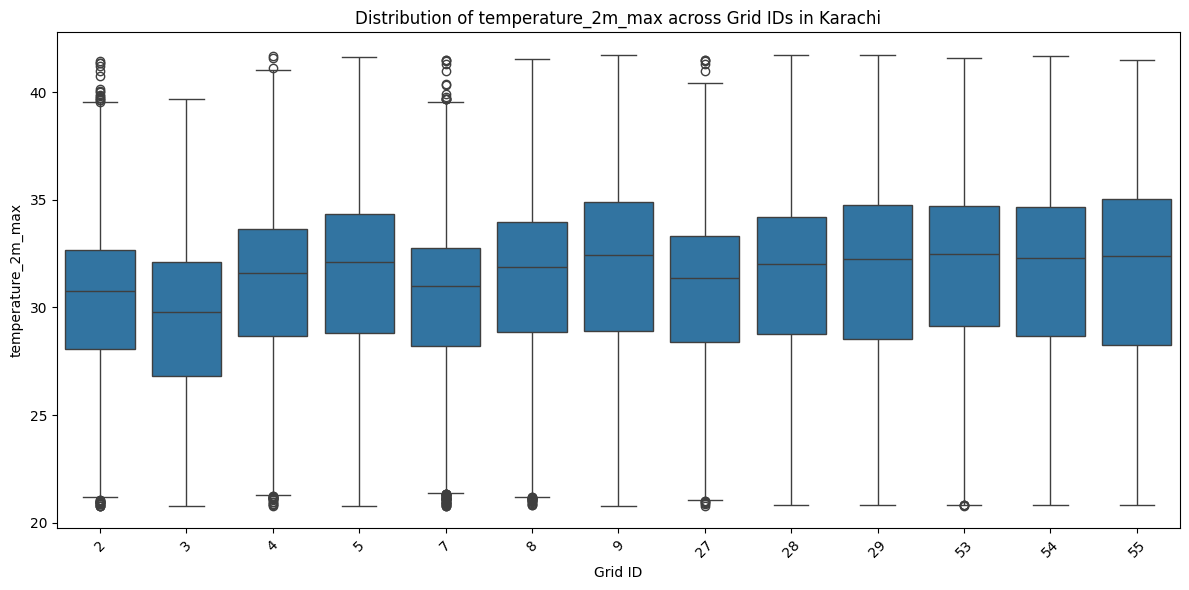

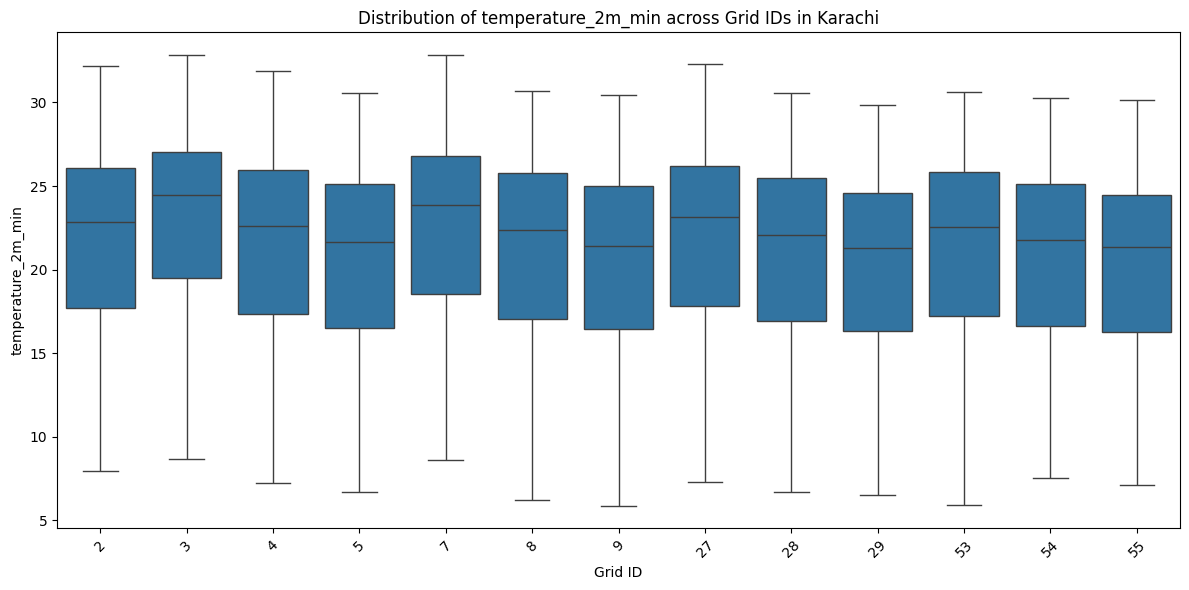

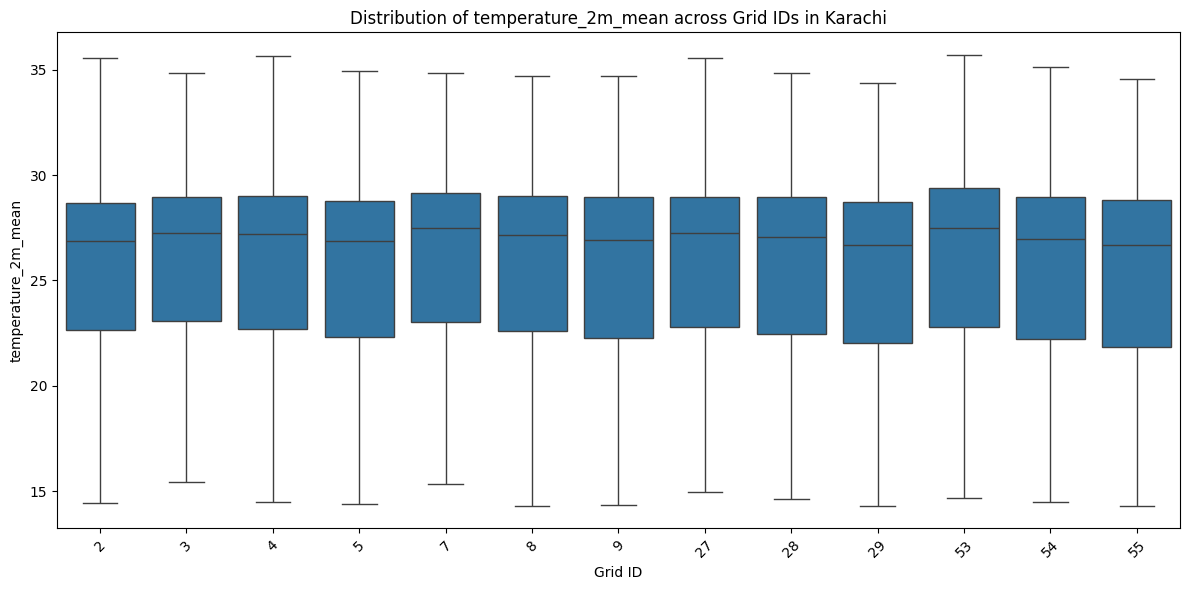

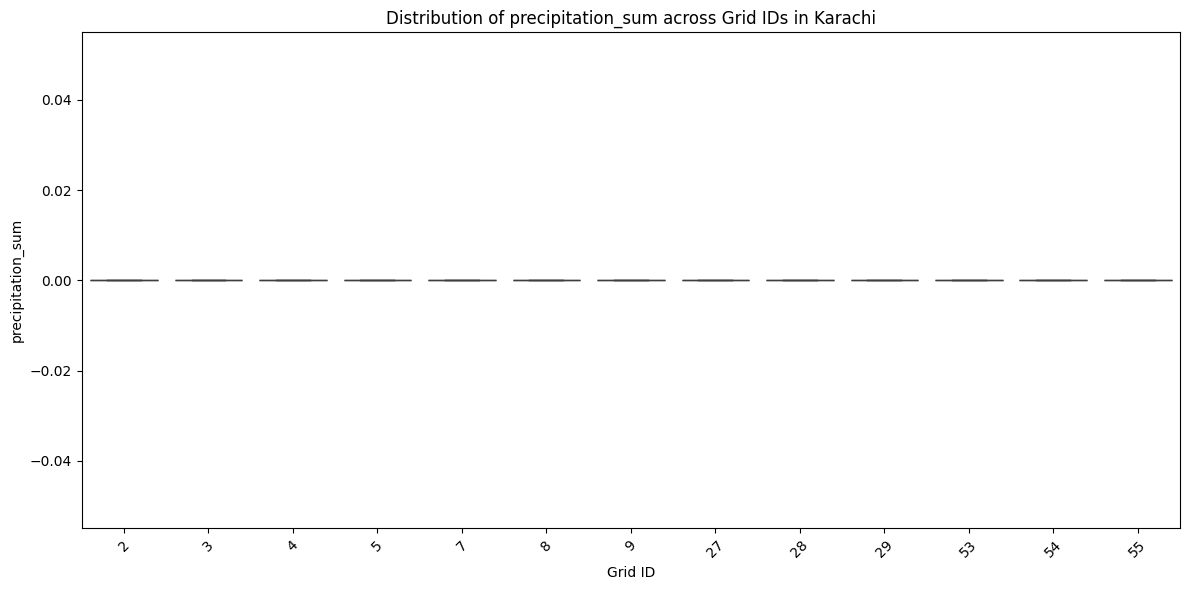

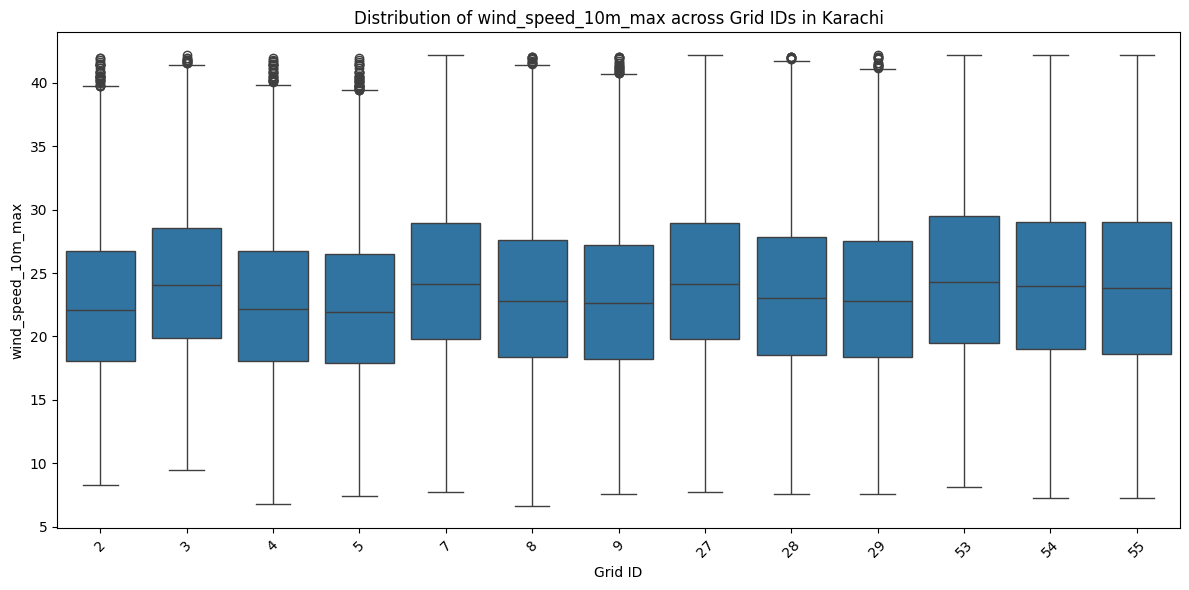

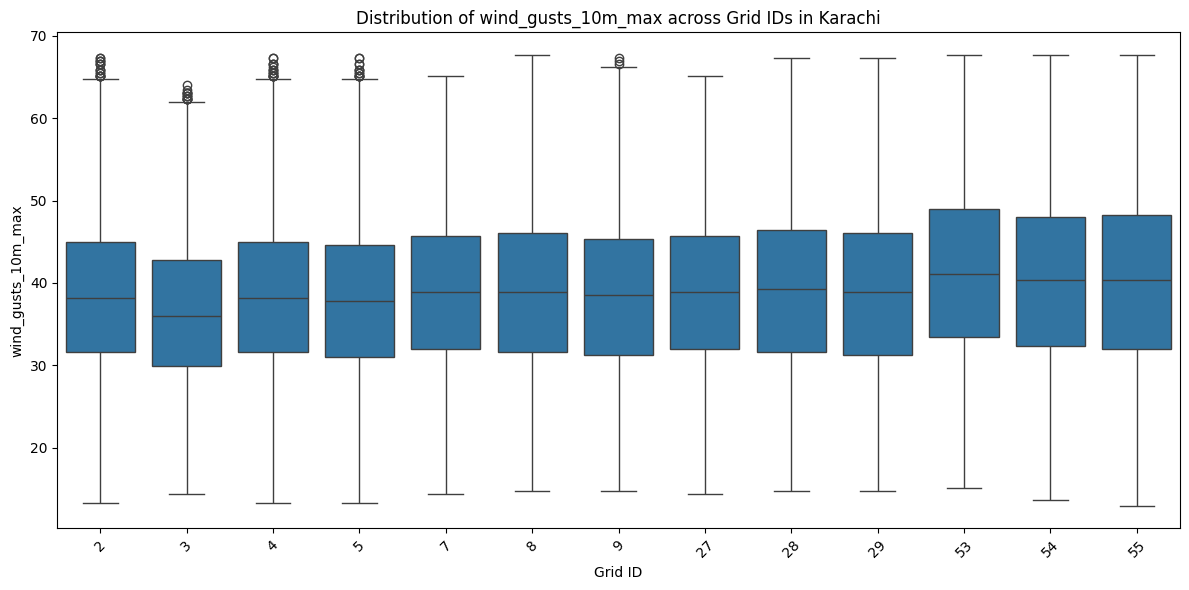

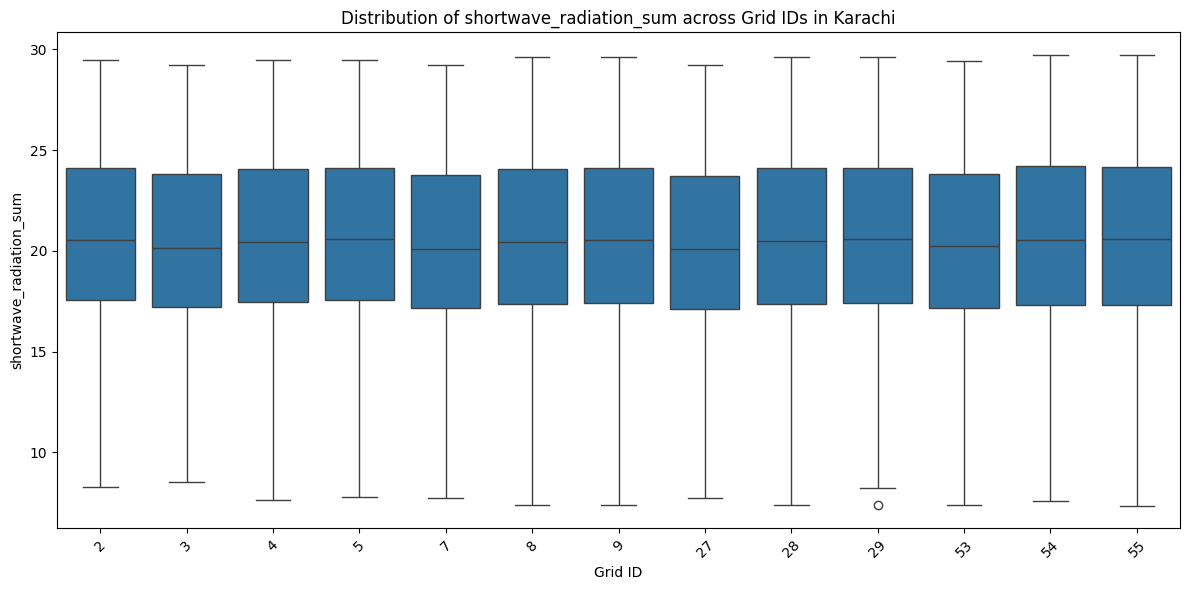

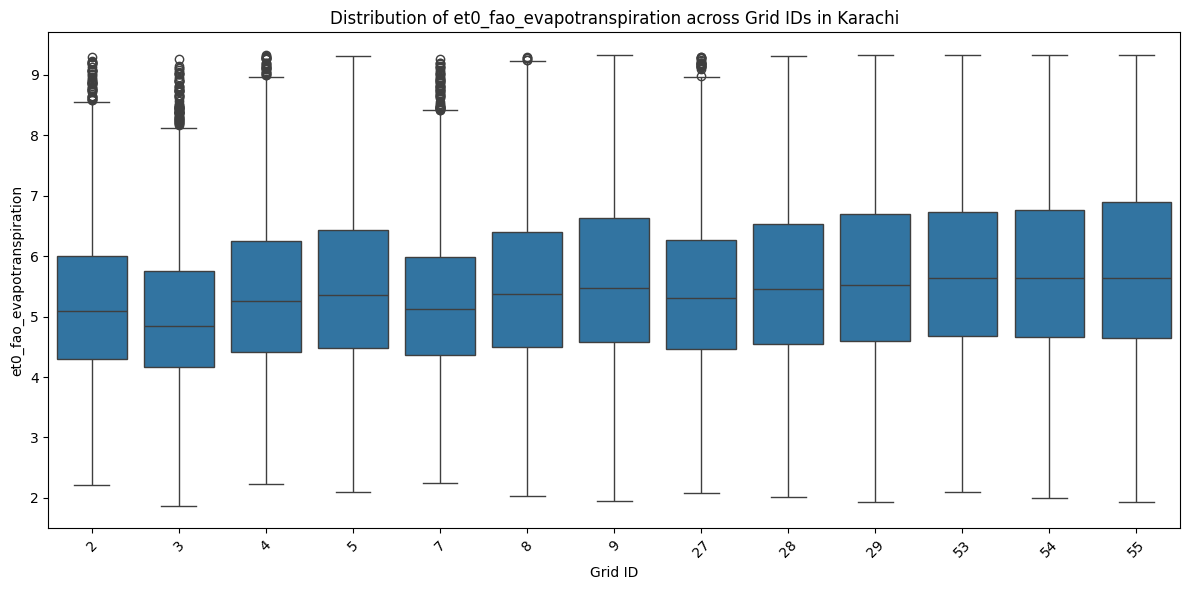

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is named `df`
# Filter only the relevant grids
df_karachi = pd.read_parquet('/content/drive/MyDrive/FYP/fresh data/karachi_combined_grid_data.parquet')
df_cleaned= pd.read_parquet('/content/drive/MyDrive/FYP/fresh data/karachi_combined_grid_data(cleaned).parquet')
# Convert date to datetime if not already
df_karachi['date'] = pd.to_datetime(df_karachi['date'])
df_cleaned['date'] = pd.to_datetime(df_karachi['date'])

# Calculate mean and std for each parameter grouped by grid_id
# stats_by_grid = df_karachi.groupby('grid_id').agg(['mean', 'std', 'min', 'max'])
# print(stats_by_grid)

# Plotting boxplots to see distribution differences for each parameter
variables_to_plot = ['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
                     'precipitation_sum', 'wind_speed_10m_max', 'wind_gusts_10m_max',
                     'shortwave_radiation_sum', 'et0_fao_evapotranspiration']

for var in variables_to_plot:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='grid_id', y=var, data=df_cleaned)
    plt.title(f'Distribution of {var} across Grid IDs in Karachi')
    plt.xlabel('Grid ID')
    plt.ylabel(var)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



In [ ]:
summary = df_karachi.groupby('grid_id')[['temperature_2m_max', 'precipitation_sum']].agg(['mean', 'std', 'min', 'max'])
summary

temperature_2m_max                                 precipitation_sum  \
                      mean       std        min        max              mean   
grid_id                                                                        
2                30.283686  3.635464  16.152500  45.059002          0.455366   
3                29.274584  3.598767  16.395500  41.245502          0.480563   
4                31.044440  3.817721  15.987000  46.343500          0.469842   
5                31.392878  4.154875  15.980500  44.796000          0.436498   
7                30.384319  3.446654  16.389000  42.841503          0.497733   
8                31.314986  3.954855  15.954500  47.287000          0.531384   
9                31.817422  4.413232  15.775500  47.101997          0.514488   
27               30.737850  3.634887  16.074001  43.024000          0.497733   
28               31.424768  4.108941  15.919999  47.567497          0.534626   
29               31.519923  4.548375  15.404500  47.427002          0.507271   
53               31.849224  4.131461  16.360500  44.239002          0.546638   
54               31.595377  4.391675  15.785001  47.278500          0.606899   
55               31.610980  4.822470  15.318999  47.360500          0.580716   

                                   
              std  min        max  
grid_id                            
2        4.350248  0.0  234.10000  
3        5.227976  0.0  349.60007  
4        4.888405  0.0  330.90002  
5        3.849869  0.0  175.40001  
7        4.686441  0.0  268.00003  
8        5.766865  0.0  424.70000  
9        4.671780  0.0  297.60000  
27       4.686441  0.0  268.00003  
28       5.574795  0.0  402.90002  
29       4.581422  0.0  293.19998  
53       4.315851  0.0  131.99998  
54       5.098054  0.0  284.30002  
55       4.796028  0.0  256.60000

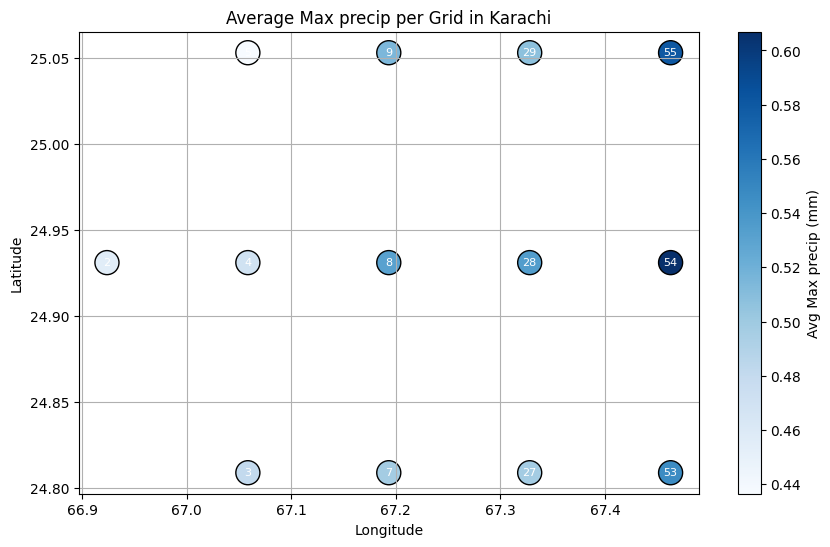

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Your climate data (assuming it’s already loaded as df)
# and the grid coordinates
grid_data = {
    'lat': [24.93096, 24.80871, 24.93096, 25.05309, 24.80871, 24.93096, 25.05309,
            24.80871, 24.93096, 25.05309, 24.80871, 24.93096, 25.05309],
    'lon': [66.92386, 67.05860, 67.05860, 67.05860, 67.19335, 67.19335, 67.19335,
            67.32810, 67.32810, 67.32810, 67.46284, 67.46284, 67.46284],
    'Grid_ID': [2, 3, 4, 5, 7, 8, 9, 27, 28, 29, 53, 54, 55]
}
grid_df = pd.DataFrame(grid_data)

# Get mean temperature per grid from the climate data
mean_temp = df_karachi.groupby('grid_id')['precipitation_sum'].mean().reset_index()

# Merge with grid coordinates
merged = pd.merge(mean_temp, grid_df, left_on='grid_id', right_on='Grid_ID')

# Plotting
plt.figure(figsize=(10, 6))
sc = plt.scatter(merged['lon'], merged['lat'], c=merged['precipitation_sum'], cmap='Blues', s=300, edgecolor='black')
plt.colorbar(sc, label='Avg Max precip (mm)')
plt.title('Average Max precip per Grid in Karachi')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
for i, row in merged.iterrows():
    plt.text(row['lon'], row['lat'], str(int(row['Grid_ID'])), color='white', ha='center', va='center', fontsize=8)
plt.grid(True)
plt.show()


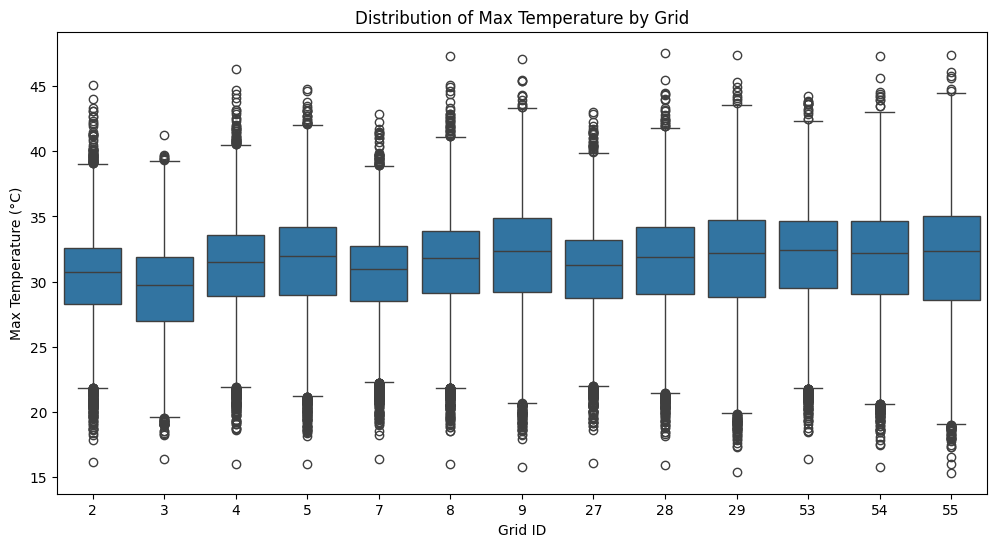

    grid_id  precipitation_sum   z_score
11       54           0.606899  2.041385


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_karachi, x='grid_id', y='temperature_2m_max')
plt.title('Distribution of Max Temperature by Grid')
plt.xlabel('Grid ID')
plt.ylabel('Max Temperature (°C)')
plt.show()

from scipy.stats import zscore

mean_temp = df_karachi.groupby('grid_id')['precipitation_sum'].mean().reset_index()
mean_temp['z_score'] = zscore(mean_temp['precipitation_sum'])

# Mark outliers
outliers = mean_temp[mean_temp['z_score'].abs() > 2]
print(outliers)


### Data Fetching Code

In [ ]:
import pandas as pd
import requests

# Define coordinates
latitude = 	24.93096
longitude = 67.0586

# Open-Meteo Historical API endpoint
url = "https://archive-api.open-meteo.com/v1/archive"

# Parameters for the request - January 2025
params = {
    "latitude": latitude,
    "longitude": longitude,
    "start_date": "2025-01-01",
    "end_date": "2025-03-31",
    "daily": [
        "temperature_2m_max",
        "temperature_2m_min",
        "temperature_2m_mean",
        "precipitation_sum",
        "wind_speed_10m_max",
        "wind_gusts_10m_max",
        "wind_direction_10m_dominant",
        "shortwave_radiation_sum",
        "et0_fao_evapotranspiration"
    ],
    "timezone": "Asia/Karachi"
}

# Fetch data
response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()

    # Extracting historical data
    historical_data = {
        "date": data["daily"]["time"],
        "temperature_2m_max": data["daily"]["temperature_2m_max"],
        "temperature_2m_min": data["daily"]["temperature_2m_min"],
        "temperature_2m_mean": data["daily"]["temperature_2m_mean"],
        "precipitation_sum": data["daily"]["precipitation_sum"],
        "wind_speed_10m_max": data["daily"]["wind_speed_10m_max"],
        "wind_gusts_10m_max": data["daily"]["wind_gusts_10m_max"],
        "wind_direction_10m_dominant": data["daily"]["wind_direction_10m_dominant"],
        "shortwave_radiation_sum": data["daily"]["shortwave_radiation_sum"],
        "et0_fao_evapotranspiration": data["daily"]["et0_fao_evapotranspiration"]
    }

    # Convert to DataFrame
    df = pd.DataFrame(historical_data)
else:
    print(f"Error fetching data: {response.status_code}")


#Adding new data to df

import pandas as pd
import requests
import time

# 1. Load existing Karachi data
karachi_df = pd.read_parquet("/content/drive/MyDrive/FYP/fresh data/karachi_combined_grid_data.parquet")

# 2. Grid info
grid_points = [
    (24.93096, 66.92386, 2),
    (24.80871, 67.0586, 3),
    (24.93096, 67.0586, 4),
    (25.05309, 67.0586, 5),
    (24.80871, 67.19335, 7),
    (24.93096, 67.19335, 8),
    (25.05309, 67.19335, 9),
    (24.80871, 67.3281, 27),
    (24.93096, 67.3281, 28),
    (25.05309, 67.3281, 29),
    (24.80871, 67.46284, 53),
    (24.93096, 67.46284, 54),
    (25.05309, 67.46284, 55),
]

# 3. Function to fetch data for one grid
def fetch_grid_data(lat, lon, grid_id):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": "2025-01-01",
        "end_date": "2025-03-31",
        "daily": [
            "temperature_2m_max",
            "temperature_2m_min",
            "temperature_2m_mean",
            "precipitation_sum",
            "wind_speed_10m_max",
            "wind_gusts_10m_max",
            "wind_direction_10m_dominant",
            "shortwave_radiation_sum",
            "et0_fao_evapotranspiration"
        ],
        "timezone": "Asia/Karachi"
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        historical_data = {
            "date": data["daily"]["time"],
            "temperature_2m_max": data["daily"]["temperature_2m_max"],
            "temperature_2m_min": data["daily"]["temperature_2m_min"],
            "temperature_2m_mean": data["daily"]["temperature_2m_mean"],
            "precipitation_sum": data["daily"]["precipitation_sum"],
            "wind_speed_10m_max": data["daily"]["wind_speed_10m_max"],
            "wind_gusts_10m_max": data["daily"]["wind_gusts_10m_max"],
            "wind_direction_10m_dominant": data["daily"]["wind_direction_10m_dominant"],
            "shortwave_radiation_sum": data["daily"]["shortwave_radiation_sum"],
            "et0_fao_evapotranspiration": data["daily"]["et0_fao_evapotranspiration"]
        }

        df = pd.DataFrame(historical_data)
        df['grid_id'] = grid_id
        return df
    else:
        print(f"❌ Failed for Grid {grid_id} - Status {response.status_code}")
        return None

# 4. Fetch data for all grids
new_data = []
for lat, lon, grid_id in grid_points:
    print(f"📦 Fetching for grid_id {grid_id}...")
    df = fetch_grid_data(lat, lon, grid_id)
    if df is not None:
        new_data.append(df)
    time.sleep(1)

# 5. Combine new data and append to old
if new_data:
    new_df = pd.concat(new_data, ignore_index=True)
    combined_df = pd.concat([karachi_df, new_df], ignore_index=True)

    # Save updated dataset
    combined_df.to_parquet("/content/drive/MyDrive/FYP/fresh data/karachi_combined_grid_data(updated).parquet", index=False)
    print("✅ Appended and saved successfully!")
else:
    print("⚠️ No new data to append.")


📦 Fetching for grid_id 2...
📦 Fetching for grid_id 3...
📦 Fetching for grid_id 4...
📦 Fetching for grid_id 5...
📦 Fetching for grid_id 7...
📦 Fetching for grid_id 8...
📦 Fetching for grid_id 9...
📦 Fetching for grid_id 27...
📦 Fetching for grid_id 28...
📦 Fetching for grid_id 29...
📦 Fetching for grid_id 53...
📦 Fetching for grid_id 54...
📦 Fetching for grid_id 55...
✅ Appended and saved successfully!


### Data Cleaning

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/FYP/fresh data/karachi_combined_grid_data.parquet') #grids 5,9,55 showing mild drought
import pandas as pd

# List of numeric columns to check
cols = [
    'temperature_2m_max',
    'temperature_2m_min',
    'temperature_2m_mean',
    'precipitation_sum',
    'wind_speed_10m_max',
    'wind_gusts_10m_max',
    'shortwave_radiation_sum',
    'et0_fao_evapotranspiration'
]

print("Initial shape:", df.shape)

# IQR filtering
for col in cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    before = df.shape[0]
    df = df[(df[col] >= lower) & (df[col] <= upper)]
    after = df.shape[0]
    print(f"{col}: Removed {before - after} rows")

# Reset index
df.reset_index(drop=True, inplace=True)

print("Final shape after IQR-based filtering:", df.shape)

# Reset index after cleaning
df.reset_index(drop=True, inplace=True)

print("Cleaned data shape:", df.shape)

df_cleaned = df.copy()  # after applying the outlier cleaning

import matplotlib.pyplot as plt

# Columns to visualize
cols = [
    'temperature_2m_max',
    'temperature_2m_min',
    'temperature_2m_mean',
    'precipitation_sum',
    'wind_speed_10m_max',
    'wind_gusts_10m_max',
    'shortwave_radiation_sum',
    'et0_fao_evapotranspiration'
]

for col in cols:
    plt.figure(figsize=(10, 4))

    # Original
    plt.subplot(1, 2, 1)
    plt.hist(df[col], bins=40, color='salmon', alpha=0.7)
    plt.title(f'Original - {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Cleaned
    plt.subplot(1, 2, 2)
    plt.hist(df_cleaned[col], bins=40, color='seagreen', alpha=0.7)
    plt.title(f'Cleaned - {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

df_cleaned.to_parquet('/content/drive/MyDrive/FYP/fresh data/karachi_combined_grid_data(cleaned).parquet')

# XGBoost Drought (Karachi Single Grid)

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Define the actual features from the dataset
raw_features = [
    'date', 'temperature_2m_max', 'temperature_2m_min',
    'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max',
    'wind_gusts_10m_max', 'wind_direction_10m_dominant',
    'shortwave_radiation_sum', 'et0_fao_evapotranspiration'
]

 # ----------------------
# 1. Load and prepare data
# ----------------------
def load_data(filepath='/content/drive/MyDrive/FYP/fresh data/karachi_combined_grid_data.parquet'):
    """
    Load climate data for Karachi
    """
    try:
        df = pd.read_parquet(filepath)
        df=df[(df['grid_id'] == 4)]
        df.drop(('grid_id'), axis=1, inplace=True)

        print(f"Data loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns")
        return df
    except FileNotFoundError:
        print("File not found. Please provide the correct path to your data.")
        return None


# ----------------------
# 2. Calculate SPI and define drought levels
# ----------------------
def calculate_spi(df, periods=[1, 3, 6, 12], base_column='precipitation_sum'):
    """
    Calculate Standardized Precipitation Index (SPI) for different time scales

    Parameters:
    df (pandas.DataFrame): DataFrame containing precipitation data
    periods (list): List of periods (months) to calculate SPI for
    base_column (str): Column name containing precipitation data

    Returns:
    pandas.DataFrame: Input DataFrame with additional SPI columns
    """
    if df is None:
        return None

    # Convert date to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'])

    # Create a copy to avoid modifying the original DataFrame
    df_spi = df.copy()

    # Group data by month for monthly aggregation
    df_spi['year'] = df_spi['date'].dt.year
    df_spi['month'] = df_spi['date'].dt.month

    # Aggregate to monthly data if the input is daily
    if len(df_spi) > 12 * 24:  # If we have more than 24 years of data, assume it's daily
        print("Input data appears to be daily. Aggregating to monthly data...")
        monthly_data = df_spi.groupby(['year', 'month'])[base_column].sum().reset_index()

        # Convert back to datetime format for time series operations
        monthly_data['date'] = pd.to_datetime(monthly_data[['year', 'month']].assign(day=1))
        monthly_data = monthly_data.sort_values('date')
    else:
        # Data is already monthly
        monthly_data = df_spi[['year', 'month', 'date', base_column]].copy()

    # Calculate SPI for each period
    for period in periods:
        # Create column name for this SPI period
        col_name = f'SPI_{period}'

        # Create rolling sum for the period
        rolling_sum = monthly_data[base_column].rolling(window=period, min_periods=period).sum()

        # For each month, collect all historic values for this month and the rolling sum
        spi_values = []

        for i in range(len(monthly_data)):
            # Skip if we don't have enough data for the rolling window
            if i < period - 1:
                spi_values.append(np.nan)
                continue

            current_month = monthly_data['month'].iloc[i]

            # Get historical values for the same month
            historical_values = []
            for j in range(i, -1, -period):
                if monthly_data['month'].iloc[j] == current_month:
                    historical_values.append(rolling_sum.iloc[j])

            # Calculate SPI using gamma distribution
            if len(historical_values) >= 3:  # Need at least a few values for the distribution
                # Avoid zeros by adding a small constant (precipitation data can have zeros)
                historical_array = np.array(historical_values) + 0.01

                try:
                    # Fit a gamma distribution to the historical data
                    shape, loc, scale = stats.gamma.fit(historical_array, floc=0)

                    # Calculate the cumulative probability of the current value
                    current_value = rolling_sum.iloc[i] + 0.01
                    cdf = stats.gamma.cdf(current_value, shape, loc=loc, scale=scale)

                    # Convert to standard normal distribution (SPI)
                    spi = stats.norm.ppf(cdf)

                    # Handle any infinities
                    if np.isinf(spi):
                        if spi > 0:
                            spi = 3.0  # Cap at 3 for extremely wet
                        else:
                            spi = -3.0  # Cap at -3 for extremely dry
                except:
                    # If there's an error fitting the distribution, use a simpler approach
                    mean = np.mean(historical_array)
                    std = np.std(historical_array)
                    if std == 0:
                        spi = 0
                    else:
                        spi = (current_value - mean) / std
            else:
                spi = np.nan

            spi_values.append(spi)

        # Add SPI values to the DataFrame
        monthly_data[col_name] = spi_values

    # Define drought levels based on SPI values (standard classification)
    for period in periods:
        spi_col = f'SPI_{period}'
        drought_level_col = f'drought_level_{period}'

        def classify_drought(spi):
            if pd.isna(spi):
                return np.nan
            elif spi > 2.0:
                return 6  # Extremely wet (was 4)
            elif spi > 1.5:
                return 5  # Very wet (was 3)
            elif spi > 1.0:
                return 4  # Moderately wet (was 2)
            elif spi > -1.0:
                return 3  # Near normal (was 1)
            elif spi > -1.5:
                return 2  # Moderately dry (was 0)
            elif spi > -2.0:
                return 1  # Severely dry (was -1)
            else:
                return 0  # Extremely dry (was -2)

        monthly_data[drought_level_col] = monthly_data[spi_col].apply(classify_drought)
    # Merge the monthly SPI data back to the original DataFrame
    if len(df_spi) > len(monthly_data):
        # If original data is daily, merge based on year and month
        df_spi = df_spi.merge(monthly_data.drop(columns=[base_column]),
                              on=['year', 'month'],
                              how='left',
                              suffixes=('', '_y'))

        # Drop the duplicate date column
        if 'date_y' in df_spi.columns:
            df_spi = df_spi.drop(columns=['date_y'])
    else:
        # If original data is monthly, use the monthly_data as is
        df_spi = monthly_data

    # Display SPI statistics
    for period in periods:
        spi_col = f'SPI_{period}'
        drought_level_col = f'drought_level_{period}'

        print(f"\nSPI-{period} Statistics:")
        print(df_spi[spi_col].describe())

        print(f"\nDrought Level Distribution for {period}-month SPI:")
        print(df_spi[drought_level_col].value_counts().sort_index())

        # Plot SPI time series
        plt.figure(figsize=(15, 6))
        plt.plot(df_spi['date'], df_spi[spi_col], marker='o', linestyle='-', alpha=0.7)
        plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        plt.axhline(y=-1, color='r', linestyle='--', alpha=0.5, label='Moderate Drought Threshold')
        plt.axhline(y=-1.5, color='r', linestyle='-', alpha=0.5, label='Severe Drought Threshold')
        plt.axhline(y=-2, color='darkred', linestyle='-', alpha=0.5, label='Extreme Drought Threshold')
        plt.title(f'SPI-{period} Time Series for Karachi')
        plt.xlabel('Date')
        plt.ylabel(f'SPI-{period} Value')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'spi_{period}_time_series.png')
        plt.close()

    return df_spi

# ----------------------
# 3. Feature Engineering
# ----------------------
def engineer_features(df):
    """
    Create derived features from the raw climate data
    """
    if df is None:
        return None

    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Extract date features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day if 'day' not in df.columns else df['day']
    df['dayofyear'] = df['date'].dt.dayofyear

    # Create a season feature (meteorological seasons)
    df['season'] = df['month'].apply(lambda month:
                                      'Winter' if month in [12, 1, 2] else
                                      'Spring' if month in [3, 4, 5] else
                                      'Summer' if month in [6, 7, 8] else
                                      'Fall')
    # Encode season
    season_mapping = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Fall': 3}
    df['season_encoded'] = df['season'].map(season_mapping)

    # Calculate temperature range
    df['temperature_range'] = df['temperature_2m_max'] - df['temperature_2m_min']

    # Calculate rolling statistics for precipitation
    df['precipitation_30d_sum'] = df['precipitation_sum'].rolling(window=30, min_periods=1).sum()
    df['precipitation_60d_sum'] = df['precipitation_sum'].rolling(window=60, min_periods=1).sum()
    df['precipitation_90d_sum'] = df['precipitation_sum'].rolling(window=90, min_periods=1).sum()

    # Calculate dry days (days with precipitation below threshold)
    drought_threshold = 1.0  # 1mm of precipitation
    df['is_dry_day'] = (df['precipitation_sum'] < drought_threshold).astype(int)
    df['dry_days_30d'] = df['is_dry_day'].rolling(window=30, min_periods=1).sum()

    # Calculate evapotranspiration to precipitation ratio (higher values indicate drought conditions)
    df['aridity_index'] = df['et0_fao_evapotranspiration'] / (df['precipitation_sum'].replace(0, 0.1))

    # Calculate water balance (precipitation - evapotranspiration)
    df['water_balance'] = df['precipitation_sum'] - df['et0_fao_evapotranspiration']
    df['water_balance_30d'] = df['water_balance'].rolling(window=30, min_periods=1).sum()

    # Handle direction as a cyclical feature
    if 'wind_direction_10m_dominant' in df.columns:
        # Convert wind direction to radians
        wind_dir_rad = np.radians(df['wind_direction_10m_dominant'])
        # Create sine and cosine components
        df['wind_direction_sin'] = np.sin(wind_dir_rad)
        df['wind_direction_cos'] = np.cos(wind_dir_rad)

    print("\nEngineered Features:")
    print(df.columns.tolist())

    return df

# ----------------------
# 4. Data preprocessing and EDA
# ----------------------
def preprocess_data(df, target_column='drought_level_3'):
    """
    Preprocess data and perform exploratory data analysis

    Parameters:
    df (pandas.DataFrame): DataFrame with climate data and SPI-based drought levels
    target_column (str): Column name for the target drought level

    Returns:
    tuple: Processed training and test data, preprocessor
    """
    if df is None:
        return None, None, None, None, None

    # Select features for the model
    engineered_features = [
        'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
        'precipitation_sum', 'wind_speed_10m_max', 'wind_gusts_10m_max',
        'shortwave_radiation_sum', 'et0_fao_evapotranspiration', 'month',
        'season_encoded', 'temperature_range', 'precipitation_30d_sum',
        'precipitation_60d_sum', 'precipitation_90d_sum',
        'dry_days_30d', 'aridity_index', 'water_balance', 'water_balance_30d'
    ]

    # Add wind direction features if available
    if 'wind_direction_sin' in df.columns and 'wind_direction_cos' in df.columns:
        engineered_features.extend(['wind_direction_sin', 'wind_direction_cos'])

    # Check for missing values
    missing_values = df[engineered_features + [target_column]].isnull().sum()
    print("\nMissing Values:")
    print(missing_values)

    # Handle missing values
    df = df.dropna(subset=[target_column])  # Can't have missing target
    df = df.fillna(method='ffill')  # Forward fill for time series data

    # Basic statistics
    print("\nBasic Statistics:")
    print(df[engineered_features + [target_column]].describe())

    # Plot correlation with target
    plt.figure(figsize=(12, 8))
    corr_with_target = df[engineered_features + [target_column]].corr()[target_column].sort_values()
    corr_with_target.plot(kind='barh')
    plt.title(f'Feature Correlation with {target_column}')
    plt.tight_layout()
    plt.savefig('feature_target_correlation.png')
    plt.close()

    # Plot correlation heatmap
    plt.figure(figsize=(14, 12))
    corr = df[engineered_features + [target_column]].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, annot=False, cmap='coolwarm', fmt='.2f', square=True)
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.savefig('feature_correlation.png')
    plt.close()

    # Create feature matrix and target
    X = df[engineered_features]
    y = df[target_column]

    # Handle multi-class target
    print("\nTarget Distribution:")
    print(y.value_counts().sort_index())

    # Create preprocessing pipeline
    preprocessor = StandardScaler()

    # Split the data
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df[target_column])

    X_train = df_train[engineered_features]
    y_train = df_train[target_column]
    X_test = df_test[engineered_features]
    y_test = df_test[target_column]

    # Fit the preprocessor on training data
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    print(f"\nTraining set size: {X_train.shape}")
    print(f"Testing set size: {X_test.shape}")

    # Return processed data and feature names for reference
    return X_train_processed, X_test_processed, y_train, y_test, preprocessor, engineered_features

# ----------------------
# 5. Train and tune XGBoost model
# ----------------------
def train_xgboost(X_train, y_train, engineered_features=None):
    """
    Train and tune XGBoost model for multi-class drought level prediction
    """
    if X_train is None or y_train is None:
        return None

    print("\nTraining XGBoost model for drought level prediction...")

    # Check number of classes
    n_classes = len(np.unique(y_train))
    print(f"Number of drought level classes: {n_classes}")

    # Initial model with default parameters
    if n_classes > 2:
        # Multi-class classification
        xgb_model = xgb.XGBClassifier(
            objective='multi:softmax',
            num_class=n_classes,
            random_state=42,
            use_label_encoder=False,
            eval_metric='mlogloss'
        )
    else:
        # Binary classification
        xgb_model = xgb.XGBClassifier(
            objective='binary:logistic',
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        )

    # Cross-validation to evaluate baseline model
    cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Baseline Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Hyperparameter tuning with GridSearchCV
    print("\nPerforming hyperparameter tuning...")
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    # For demonstration purposes, use a smaller grid
    small_param_grid = {
        'n_estimators': [100],
        'max_depth': [5],
        'learning_rate': [0.1],
    }

    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=small_param_grid,  # Use small_param_grid for quick execution, param_grid for thorough tuning
        scoring='accuracy',
        cv=5,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

    # Train final model with best parameters
    best_xgb_model = grid_search.best_estimator_
    best_xgb_model.fit(X_train, y_train)

    # Get feature importance
    importance = best_xgb_model.feature_importances_

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    if engineered_features is not None:
        feature_importance = pd.DataFrame({
            'Feature': engineered_features,
            'Importance': importance
        }).sort_values('Importance', ascending=False)

        sns.barplot(x='Importance', y='Feature', data=feature_importance)
        plt.title('XGBoost Feature Importance for Drought Level Prediction')
    else:
        xgb.plot_importance(best_xgb_model, max_num_features=20)
        plt.title('XGBoost Feature Importance')

    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.close()

    return best_xgb_model

# ----------------------
# 6. Evaluate model
# ----------------------
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the trained model for drought level prediction
    """
    if model is None or X_test is None or y_test is None:
        return

    print("\nEvaluating model on test set...")
    y_pred = model.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Drought Level')
    plt.xlabel('Predicted Drought Level')
    plt.savefig('confusion_matrix.png')
    plt.close()

    # Create a more detailed confusion matrix with labels
    drought_levels = {
        0: "Extremely Dry",
        1: "Severely Dry",
        2: "Moderately Dry",
        3: "Mild Drought",
        4: "Moderately Wet",
        5: "Very Wet",
        6: "Extremely Wet"
    }

    # Get unique classes from both actual and predicted
    all_classes = np.unique(np.concatenate([y_test, y_pred]))

    # Create a DataFrame for the confusion matrix with labels
    cm_df = pd.DataFrame(cm,
                       index=[drought_levels.get(i, f"Level {i}") for i in sorted(all_classes)],
                       columns=[drought_levels.get(i, f"Level {i}") for i in sorted(all_classes)])

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Labeled Confusion Matrix')
    plt.ylabel('Actual Drought Level')
    plt.xlabel('Predicted Drought Level')
    plt.tight_layout()
    plt.savefig('labeled_confusion_matrix.png')
    plt.close()

# ----------------------
# 7. Save model and prediction function
# ----------------------
def save_model(model, preprocessor=None, engineered_features=None, spi_periods=None):
    """
    Save the trained model and related components for future use
    """
    if model is None:
        return

    print("\nSaving model and components...")

    # Save model
    model.save_model('/content/drive/MyDrive/FYP/processed_data/drought_prediction_model.json')

    # Save preprocessor and feature list
    if preprocessor is not None or engineered_features is not None or spi_periods is not None:
        import joblib
        components = {
            'preprocessor': preprocessor,
            'engineered_features': engineered_features,
            'spi_periods': spi_periods
        }
        joblib.dump(components, '/content/drive/MyDrive/FYP//processed_data/model_components.joblib')

    print("Model and components saved successfully.")

# ----------------------
# 8. Prediction Function for New Data
# ----------------------
def predict_drought_from_forecast(forecast_data, model_path='/content/drive/MyDrive/FYP//processed_data/drought_prediction_model.json', components_path='/content/drive/MyDrive/FYP//processed_data/model_components.joblib'):
    """
    Predict drought level from forecast data

    Parameters:
    forecast_data (dict): Dictionary containing forecast data for a month
    model_path (str): Path to the saved XGBoost model
    components_path (str): Path to the saved model components

    Returns:
    dict: Prediction results including drought level and probability
    """
    import joblib

    # Load model and components
    model = xgb.XGBClassifier()
    model.load_model(model_path)

    components = joblib.load(components_path)
    preprocessor = components['preprocessor']
    engineered_features = components['engineered_features']

    # Convert forecast data to DataFrame
    if isinstance(forecast_data, dict):
        forecast_df = pd.DataFrame([forecast_data])
    else:
        forecast_df = forecast_data.copy()

    # Engineer features for the forecast data
    for feature in engineered_features:
        if feature not in forecast_df.columns:
            if feature == 'season_encoded':
                # Calculate season from month
                if 'month' in forecast_df.columns:
                    month = forecast_df['month'].iloc[0]
                    season = 0 if month in [12, 1, 2] else 1 if month in [3, 4, 5] else 2 if month in [6, 7, 8] else 3
                    forecast_df['season_encoded'] = season
                else:
                    forecast_df['season_encoded'] = 0  # Default to winter if month not provided

            elif feature == 'temperature_range':
                if 'temperature_2m_max' in forecast_df.columns and 'temperature_2m_min' in forecast_df.columns:
                    forecast_df['temperature_range'] = forecast_df['temperature_2m_max'] - forecast_df['temperature_2m_min']
                else:
                    forecast_df['temperature_range'] = 0  # Default value

            elif feature == 'wind_direction_sin':
                if 'wind_direction_10m_dominant' in forecast_df.columns:
                    forecast_df['wind_direction_sin'] = np.sin(np.radians(forecast_df['wind_direction_10m_dominant']))
                else:
                    forecast_df['wind_direction_sin'] = 0  # Default value

            elif feature == 'wind_direction_cos':
                if 'wind_direction_10m_dominant' in forecast_df.columns:
                    forecast_df['wind_direction_cos'] = np.cos(np.radians(forecast_df['wind_direction_10m_dominant']))
                else:
                    forecast_df['wind_direction_cos'] = 1  # Default value

            elif feature in ['precipitation_30d_sum', 'precipitation_60d_sum', 'precipitation_90d_sum']:
                # Use the current precipitation as a proxy if historical data isn't available
                if 'precipitation_sum' in forecast_df.columns:
                    forecast_df[feature] = forecast_df['precipitation_sum'] * 30  # Approximate for a month
                else:
                    forecast_df[feature] = 0  # Default value

            elif feature == 'dry_days_30d':
                if 'precipitation_sum' in forecast_df.columns:
                    forecast_df['dry_days_30d'] = (forecast_df['precipitation_sum'] < 1.0).astype(int) * 30  # Approximate
                else:
                    forecast_df['dry_days_30d'] = 15  # Default middle value

            elif feature == 'aridity_index':
                if 'et0_fao_evapotranspiration' in forecast_df.columns and 'precipitation_sum' in forecast_df.columns:
                    forecast_df['aridity_index'] = forecast_df['et0_fao_evapotranspiration'] / forecast_df['precipitation_sum'].replace(0, 0.1)
                else:
                    forecast_df['aridity_index'] = 1.0  # Default value

            elif feature == 'water_balance':
                if 'precipitation_sum' in forecast_df.columns and 'et0_fao_evapotranspiration' in forecast_df.columns:
                    forecast_df['water_balance'] = forecast_df['precipitation_sum'] - forecast_df['et0_fao_evapotranspiration']
                else:
                    forecast_df['water_balance'] = 0  # Default value

            elif feature == 'water_balance_30d':
                if 'water_balance' in forecast_df.columns:
                    forecast_df['water_balance_30d'] = forecast_df['water_balance'] * 30  # Approximate for a month
                elif 'precipitation_sum' in forecast_df.columns and 'et0_fao_evapotranspiration' in forecast_df.columns:
                    forecast_df['water_balance_30d'] = (forecast_df['precipitation_sum'] - forecast_df['et0_fao_evapotranspiration']) * 30
                else:
                    forecast_df['water_balance_30d'] = 0  # Default value

            else:
                # For any other missing features, set to 0 or mean value
                forecast_df[feature] = 0

    # Select and order features to match the model's expectations
    X_forecast = forecast_df[engineered_features]

    # Preprocess the data
    X_forecast_processed = preprocessor.transform(X_forecast)

    # Make prediction
    drought_level = model.predict(X_forecast_processed)[0]

    # Get probabilities
    probabilities = model.predict_proba(X_forecast_processed)[0]

    # Map numeric drought level to category
    drought_categories = {
        0: "Extremely Dry",
        1: "Severely Dry",
        2: "Moderately Dry",
        3: "Mild Drought",
        4: "Moderately Wet",
        5: "Very Wet",
        6: "Extremely Wet"
    }

    drought_category = drought_categories.get(drought_level, f"Level {drought_level}")

    # Format class probabilities
    class_labels = [drought_categories.get(i, f"Level {i}") for i in model.classes_]
    probability_dict = {class_labels[i]: float(probabilities[i]) for i in range(len(class_labels))}

    # Return prediction results
    results = {
        'drought_level_numeric': int(drought_level),
        'drought_category': drought_category,
        'confidence': float(max(probabilities)),
        'class_probabilities': probability_dict
    }

    return results

# ----------------------
# 9. Example Usage of the Prediction Function
# ----------------------
def example_forecast_prediction(df):
    """
    Example of how to use the prediction function with forecast data
    """
    # Sample forecast data for a month
    forecast_data = df

    # Make prediction
    prediction = predict_drought_from_forecast(forecast_data)

    print("Forecast Prediction Results:")
    print(f"Predicted Drought Level: {prediction['drought_category']}")
    print(f"Confidence: {prediction['confidence'] * 100:.2f}%")
    print("\nClass Probabilities:")
    for cls, prob in prediction['class_probabilities'].items():
      print(f"{cls}: {prob * 100:.2f}%")


    pass

# ----------------------
# 10. Main execution
# ----------------------
def main():
    """
    Main execution function for the drought prediction pipeline
    """
    print("Starting Drought Prediction Pipeline...")

    # 1. Load data
    df = load_data()
    if df is None:
        return

    # 2. Calculate SPI and drought levels
    spi_periods = [1, 3, 6, 12]  # SPI periods to calculate
    df_spi = calculate_spi(df, periods=spi_periods)

    # 3. Feature engineering
    df_engineered = engineer_features(df_spi)

    # 4. Preprocess data (using 3-month SPI drought level as target)
    X_train, X_test, y_train, y_test, preprocessor, engineered_features = preprocess_data(
        df_engineered,
        target_column='drought_level_3'
    )

    # 5. Train XGBoost model
    model = train_xgboost(X_train, y_train, engineered_features)

    # 6. Evaluate model
    evaluate_model(model, X_test, y_test)

    # 7. Save model and components
    save_model(model, preprocessor, engineered_features, spi_periods)

    # 8. Example prediction
    example_forecast_prediction()

    print("\nPipeline execution completed.")

#if __name__ == "__main__":
 #   main()

# LSTM DROUGHT

### Feature engineering

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/FYP/fresh data/karachi_combined_grid_data.parquet')

df=df[(df['grid_id'] == 4)]
df.drop(('grid_id'), axis=1, inplace=True)

df['date'] = pd.to_datetime(df['date'])

start_date = '2024-09-01'
end_date = '2024-12-31'
december_2024_data = df[(df['date'] >= start_date) & (df['date'] <= end_date) ]
december_2024_data['date'] = december_2024_data['date'].dt.date

df = pd.read_csv("/content/drive/MyDrive/FYP/fresh data/Datasets for model comparison/karachi_data_openmeteo_2025.csv")

df['date'] = pd.to_datetime(df['date'])

start_date = '2025-01-01'
end_date = '2025-03-25'
january_2025_forecast_data = df[(df['date'] >= start_date) & (df['date'] <= end_date) ]
january_2025_forecast_data['date'] = january_2025_forecast_data['date'].dt.date

def preprocess_for_lstm(df):
    # Calculate rolling features
    df['temp_mean_7d'] = df['temperature_2m_mean'].rolling(window=7).mean()
    df['temp_mean_14d'] = df['temperature_2m_mean'].rolling(window=14).mean()
    df['precip_sum_7d'] = df['precipitation_sum'].rolling(window=7).sum()
    df['precip_sum_14d'] = df['precipitation_sum'].rolling(window=14).sum()

    # Calculate Aridity Index as temperature/precipitation (this is just an example)
    # Adding a small epsilon to avoid division by zero
    df['aridity_index'] = df['temperature_2m_mean'] / (df['precipitation_sum'] + 1e-5)

    # Calculate rolling 30-day Aridity Index
    df['aridity_index_30d'] = df['aridity_index'].rolling(window=30).mean()

    # Calculate Precipitation Anomaly as the percentage deviation from the mean
    df['precip_anomaly_pct'] = (df['precipitation_sum'] - df['precipitation_sum'].mean()) / df['precipitation_sum'].mean() * 100

    # Assuming wind stress is a combination of wind speed and other related features (this needs clarification if not already calculated)
    df['wind_stress_30d'] = df['wind_speed_10m_max'].rolling(window=30).sum()  # Example using wind speed as proxy

    # Drop NaN values generated by rolling calculations
    df = df.dropna(subset=['temp_mean_7d', 'temp_mean_14d', 'precip_sum_7d', 'precip_sum_14d',
                           'aridity_index_30d', 'precip_anomaly_pct', 'wind_stress_30d'])

    # Select required features for model input
    features = ['temperature_2m_mean', 'precipitation_sum', 'et0_fao_evapotranspiration',
                'temp_mean_7d', 'temp_mean_14d', 'precip_sum_7d', 'precip_sum_14d',
                'aridity_index', 'aridity_index_30d', 'precip_anomaly_pct', 'wind_stress_30d']

    # Normalize the data using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    df[features] = scaler.fit_transform(df[features])

    return df, scaler


# Example usage
#df, scaler = preprocess_for_lstm(df)
features = ['temperature_2m_mean', 'precipitation_sum', 'et0_fao_evapotranspiration',
            'temp_mean_7d', 'temp_mean_14d', 'precip_sum_7d', 'precip_sum_14d',
            'aridity_index', 'aridity_index_30d', 'precip_anomaly_pct', 'wind_stress_30d']
df2=df
scaler1 = MinMaxScaler(feature_range=(0, 1))
df2[features] = scaler1.fit_transform(df2[features])

### EDA

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Select only the relevant features for analysis
features = [
    'temperature_2m_mean', 'precipitation_sum', 'et0_fao_evapotranspiration',
    'wind_speed_10m_max', 'wind_gusts_10m_max', 'aridity_index', 'wind_stress',
    'precip_anomaly', 'cum_precip_anomaly_30d', 'SPEI_3m', 'water_balance',
    'dry_days_30d', 'season_encoded', 'wind_direction_encoded'
]
target = 'future_drought_class'

### 1. Basic Info and Missing Values
print("Dataset shape:", df.shape)
print("\nMissing values:\n", df[features + [target]].isnull().sum())

### 2. Distribution of Drought Classes
plt.figure(figsize=(6, 4))
sns.countplot(x=target, data=df)
plt.title("Drought Class Distribution")
plt.xlabel("Drought Class (0 = No Drought, 1 = Drought)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### 3. Feature Correlation Matrix
plt.figure(figsize=(12, 10))
corr_matrix = df[features + [target]].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

### 4. Boxplots of Features vs Drought Class
for feature in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=target, y=feature, data=df)
    plt.title(f"{feature} vs Drought Class")
    plt.xlabel("Drought Class")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

### 5. Time Series Trend of Key Features
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

df['drought_class'].value_counts(normalize=True)

,proportion
drought_class,
0,0.584976
1,0.214958
2,0.108958
3,0.076873
4,0.014236


###Model Training

In [ ]:
df=process_drought_features(df)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


# Prepare data for LSTM model
features = [
    'temperature_2m_mean', 'et0_fao_evapotranspiration',
    'wind_speed_10m_max', 'aridity_index',
    'SPEI_3m', 'water_balance',
    'dry_days_30d', 'season_encoded', 'wind_direction_encoded'
]

target = 'drought_class'

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
df[features] = scaler.fit_transform(df[features])

# Create sequences of data for LSTM (X: features, y: labels)
def create_sequences(data, seq_length, feature_columns, target_column):
    X = []
    y = []

    for i in range(len(data) - seq_length):
        X.append(data[feature_columns].iloc[i:i+seq_length].values)
        y.append(data[target_column].iloc[i+seq_length])

    return np.array(X), np.array(y)

# Set sequence length (e.g., 30 days) and prepare data
seq_length = 30
X, y = create_sequences(df, seq_length, features, target)

# Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshaping data to 3D (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], len(features))
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], len(features))

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Create a dictionary for class weights
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class weights:", class_weights_dict)

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(units=5, activation='softmax'))  # 5 classes for drought levels (0-4)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weights_dict)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Make predictions
predictions = model.predict(X_test)
predictions_class = np.argmax(predictions, axis=1)

# Evaluate the model with confusion matrix and classification report
def evaluate_model(y_true, y_pred, labels=["No Drought", "Mild Drought", "Moderate Drought", "Severe Drought"]):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    print(classification_report(y_true, y_pred, target_names=labels))

evaluate_model(y_test, predictions_class)
print(df[target].value_counts())

import joblib
joblib.dump(scaler, '/content/drive/MyDrive/FYP/fresh data/drought_scaler_2000-2024.joblib')
model.save("/content/drive/MyDrive/FYP/processed_data/karachi_lstm.h5")

### Prediction

In [ ]:
december_2024_data=process_drought_features(december_2024_data)
december_2024_data[features] = scaler.transform(december_2024_data[features])

january_2025_forecast_data=process_drought_features(january_2025_forecast_data)
january_2025_forecast_data[features] = scaler.transform(january_2025_forecast_data[features])


df=january_2025_forecast_data
df["predicted_drought_class"] = predict_future_drought(model,df,features,scaler,30,days_ahead=len(df))
df["predicted_drought_category"] = df["predicted_drought_class"].map(drought_categories)
df["predicted_drought_category"]

df = pd.concat([december_2024_data[features], january_2025_forecast_data[features]], ignore_index=True)


def predict_future_drought(model, data, features, scaler, sequence_length, days_ahead=len(df)):
    # Get the last sequence from the data
    last_sequence = scaler.transform(data[features].iloc[-sequence_length:])

    # Initialize predictions array
    predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(days_ahead):
        # Reshape for prediction
        current_sequence_reshaped = current_sequence.reshape(1, sequence_length, len(features))

        # Predict the next drought class
        pred = model.predict(current_sequence_reshaped)
        predicted_class = np.argmax(pred, axis=1)[0]
        predictions.append(predicted_class)

        # For simplicity, we'll just append the same feature values but with the new predicted drought class
        # In a more sophisticated approach, you might want to have a separate model to predict the features as well
        new_row = current_sequence[-1].copy()
        # Update sequence for next prediction (remove oldest, add newest)
        current_sequence = np.vstack([current_sequence[1:], new_row])

    return predictions

    drought_categories = {
        0: "No drought",
        1: "Mild drought",
        2: "Moderate drought",
        3: "Severe drought",
        4: "Extreme drought"
    }

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━

,predicted_drought_category
0,No drought
1,No drought
2,No drought
3,No drought
4,No drought
...,...
79,No drought
80,No drought
81,No drought
82,No drought


In [ ]:
# 2. Define your features (same as in training)
# features = [
#     'temperature_2m_mean', 'et0_fao_evapotranspiration',
#     'wind_speed_10m_max', 'aridity_index',
#     'SPEI_3m', 'water_balance',
#     'dry_days_30d', 'season_encoded', 'wind_direction_encoded'
# ]


december_data_scaled= december_2024_data[features]

# 5. Create the input sequence
seq_length = 30  # Same as in your training code
X_pred = np.array([december_data_scaled[features].values])
X_pred = X_pred.reshape(1, seq_length, len(features))

# 6. Make prediction for January 1, 2025
prediction_probs = model.predict(X_pred, verbose=0)
prediction_class = np.argmax(prediction_probs, axis=1)[0]

# 7. Interpret the prediction
drought_classes = ['No Drought', 'D0', 'D1', 'D2', 'D3/D4']  # Adjust based on your class definitions
print(f"Predicted drought class for January 1, 2025: {drought_classes[prediction_class]}")
print(f"Probability distribution: {prediction_probs[0]}")

# 8. Visualize the prediction probabilities
plt.figure(figsize=(10, 6))
plt.bar(drought_classes, prediction_probs[0])
plt.title('Drought Class Probabilities for January 1, 2025')
plt.ylabel('Probability')
plt.xlabel('Drought Class')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('january_2025_prediction.png')
plt.show()

# If you want to predict for the entire month of January:
def predict_for_month(initial_data, model, scaler, features, days=31):
    """
    Make sequential predictions for an entire month.

    Parameters:
    - initial_data: DataFrame with the last 30 days before the prediction period
    - model: Trained LSTM model
    - scaler: Fitted scaler
    - features: List of feature names
    - days: Number of days to predict (31 for January)

    Returns:
    - DataFrame with predictions for the month
    """
    predictions = []
    current_data = initial_data.copy()

    for day in range(1, days+1):
        # Scale current data
        current_data_scaled = current_data.copy()
        current_data_scaled[features] = scaler.transform(current_data[features])

        # Create sequence
        X_seq = np.array([current_data_scaled[features].values])
        X_seq = X_seq.reshape(1, seq_length, len(features))

        # Predict
        pred_probs = model.predict(X_seq, verbose=0)
        pred_class = np.argmax(pred_probs, axis=1)[0]

        # Store prediction
        predictions.append({
            'date': f'2025-01-{day:02d}',
            'drought_class': drought_classes[pred_class],
            'probability': pred_probs[0][pred_class]
        })

        # Update data for next prediction by removing the oldest day
        # and appending a new day with predicted values or estimated features
        # This is a simplification - you would need actual feature values or estimates
        # Here we just reuse the last day's features as a placeholder
        new_day_features = current_data.iloc[-1:].copy()
        current_data = pd.concat([current_data.iloc[1:], new_day_features], ignore_index=True)

    return pd.DataFrame(predictions)

# Predict for entire January (optional)
january_predictions = predict_for_month(december_2024_data, model, scaler, features)
print(january_predictions)

,date,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,...,cum_precip_anomaly_60d,cum_precip_anomaly_90d,cum_precip_anomaly_180d,cum_precip_anomaly_365d,wind_stress,wind_stress_30d,is_monsoon,aridity_index,aridity_index_30d,aridity_index_90d
0,2024-09-01,30.443500,24.293499,0.585759,0.0,0.295303,32.399998,225.797200,20.73,0.260879,...,-0.246769,-0.246769,-0.246769,-0.246769,627.041632,627.041632,1,0.000000,0.000000,0.000000
1,2024-09-02,31.693500,24.993500,0.602275,0.0,0.332316,34.920000,257.035500,21.63,0.283328,...,-0.495385,-0.495385,-0.495385,-0.495385,730.861422,678.951527,1,0.000000,0.000000,0.000000
2,2024-09-03,30.643500,25.593500,0.607515,0.0,0.325066,32.399998,266.353150,17.16,0.232098,...,-0.771385,-0.771385,-0.771385,-0.771385,668.114073,675.339043,1,0.000000,0.000000,0.000000
3,2024-09-04,30.643500,25.993500,0.616329,0.0,0.513343,44.280000,262.205750,18.22,0.244652,...,-1.144615,-1.144615,-1.144615,-1.144615,1268.170477,823.546901,1,0.000000,0.000000,0.000000
4,2024-09-05,30.443500,25.893500,0.611168,0.9,0.448192,39.960000,254.249970,14.98,0.203966,...,-0.847385,-0.847385,-0.847385,-0.847385,1033.563002,865.550121,1,0.000751,0.051755,0.051755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2024-12-26,24.843500,13.093500,0.257590,0.0,0.034812,20.519999,27.595497,15.33,0.195770,...,-6.678423,-10.418423,-21.232269,-21.232269,169.463396,288.591730,0,0.000000,0.000000,0.000629
117,2024-12-27,25.493500,12.093500,0.248935,0.0,0.066332,21.960000,341.152740,15.45,0.207549,...,-6.654295,-9.770295,-21.252141,-21.252141,210.836577,286.937458,0,0.000000,0.000000,0.000629
118,2024-12-28,24.893500,11.693500,0.247744,0.0,0.070921,27.720000,46.977947,15.33,0.231677,...,-6.572628,-8.853859,-21.287398,-21.287398,271.555266,288.433692,0,0.000000,0.000000,0.000629
119,2024-12-29,25.043499,14.193500,0.291812,0.0,0.063622,23.039999,50.251453,15.18,0.214591,...,-6.434846,-8.728385,-21.435154,-21.435154,218.546003,286.524435,0,0.000000,0.000000,0.000629


### Prediction Function

In [ ]:
# Assuming `december_2024_data` and `january_2025_forecast_data` are DataFrames containing the necessary data

# Step 1: Preprocess December 2024 Data (assuming it's already processed like the forecast data)
december_df, _ = df,scaler  # Replace with actual data for December

# Step 2: Preprocess January 2025 Forecast Data
forecast_df, _ = df2,scaler1  # Replace with actual forecast data

# Step 3: Combine December 2024 and January 2025 Data
combined_df = pd.concat([december_df, forecast_df], ignore_index=True)

# Step 4: Create Sequences for LSTM (using past 30 days for prediction)
def create_sequences(data, seq_length, feature_columns):
    X = []
    for i in range(len(data) - seq_length):
        X.append(data[feature_columns].iloc[i:i+seq_length].values)
    return np.array(X)

# Step 5: Prepare data for prediction
X_combined = create_sequences(combined_df, seq_length=30, feature_columns=features)

# Reshape to 3D for LSTM input: (samples, time_steps, features)
X_combined = X_combined.reshape(X_combined.shape[0], X_combined.shape[1], len(features))

# Step 6: Predict the drought classes for January 2025 (after 30-day window from December)
predictions_combined = model.predict(X_combined)

# Get the predicted classes (using np.argmax for multi-class classification)
predictions_class_combined = np.argmax(predictions_combined, axis=1)

# Step 7: Append predictions to forecast_df
forecast_df['predicted_drought_class'] = np.append([np.nan]*30, predictions_class_combined)  # Skip first 30 days (training window)

# Step 8: Show predictions for January 2025
print(forecast_df[['date', 'predicted_drought_class']])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
         date  predicted_drought_class
0  2025-01-01                      NaN
1  2025-01-02                      NaN
2  2025-01-03                      NaN
3  2025-01-04                      NaN
4  2025-01-05                      NaN
5  2025-01-06                      NaN
6  2025-01-07                      NaN
7  2025-01-08                      NaN
8  2025-01-09                      NaN
9  2025-01-10                      NaN
10 2025-01-11                      NaN
11 2025-01-12                      NaN
12 2025-01-13                      NaN
13 2025-01-14                      NaN
14 2025-01-15                      NaN
15 2025-01-16                      NaN
16 2025-01-17                      NaN
17 2025-01-18                      NaN
18 2025-01-19                      NaN
19 2025-01-20                      NaN
20 2025-01-21                      NaN
21 2025-01-22                      NaN
22 2025-01-23                      NaN
23 2025-01-24             

In [ ]:
import numpy as np
import pandas as pd

# Function to predict drought class and probability
def predict_drought_class(model, df, dates, sequence_length=30, features=None):
    # Prepare the output
    predictions = {}

    # Ensure features are specified
    if features is None:
        features = ['temperature_2m_mean', 'precipitation_sum', 'et0_fao_evapotranspiration',
                    'temp_mean_7d', 'temp_mean_14d', 'precip_sum_7d', 'precip_sum_14d',
                    'aridity_index', 'aridity_index_30d', 'precip_anomaly_pct', 'wind_stress_30d']

    for target_date in dates:
        # Get the data for the last `sequence_length` days ending on the target date
        target_date = pd.to_datetime(target_date)

        # Define the window for 30 days: 15 days from the previous month + 15 days from the target month
        end_idx = df[df['date'] == target_date].index[0]
        start_idx = end_idx - sequence_length

        # Create the sequence (sequence_length days prior to target)
        sequence = df[features].iloc[start_idx:end_idx].values

        # Scale the sequence (ensure that the same scaler used during training is applied)
        sequence_scaled = scaler.transform(sequence)  # Use the same scaler you used for training

        # Reshape to match LSTM input shape (samples, time steps, features)
        sequence_scaled = sequence_scaled.reshape(1, sequence_length, -1)

        # Predict with the model
        prediction = model.predict(sequence_scaled)

        # Extract class and confidence (probabilities)
        drought_class = np.argmax(prediction)
        confidence = np.max(prediction)

        # Store the results
        predictions[target_date] = {
            'class': drought_class,
            'probabilities': prediction[0],  # Probabilities for each class
            'confidence': confidence
        }

    return predictions

# Example: Predict for January 1st, 2022, and January 2nd, 2022
target_dates = ['2021-01-01', '2021-03-02']
predictions = predict_drought_class(model, df, target_dates)

# Print predictions
for date, result in predictions.items():
    print(f"Date: {date}")
    print(f"Predicted Class: {result['class']}")
    print(f"Probabilities: {result['probabilities']}")
    print(f"Confidence: {result['confidence']}")
    print()


### Save the model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
# Save the entire model (architecture + weights + optimizer state)
model.save("/content/drive/MyDrive/FYP/processed_data/karachi_lstm_drought_model(new).h5")
joblib.dump(scaler, "/content/drive/MyDrive/FYP/processed_data/scaler.pkl")


,date,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration,...,aridity_index_30d,aridity_index_90d,is_monsoon,water_balance,water_balance_1m,water_balance_3m,water_balance_6m,water_balance_12m,SPEI_3m,drought_class
0,1999-12-31 19:00:00+00:00,25.937000,15.387000,19.970335,0.0,28.167557,46.079998,49.611750,16.62,6.055775,...,0.0,0.000000,0,-6.055775,-6.055775,-6.055775,-6.055775,-6.055775,2.493420,0
1,2000-01-01 19:00:00+00:00,26.337000,15.537001,20.222418,0.0,25.772078,43.199997,47.664616,16.43,5.727797,...,0.0,0.000000,0,-5.727797,-11.783572,-11.783572,-11.783572,-11.783572,2.471471,0
2,2000-01-02 19:00:00+00:00,25.687000,14.887000,19.966166,0.0,20.620804,34.560000,40.500660,16.50,4.728108,...,0.0,0.000000,0,-4.728108,-16.511679,-16.511679,-16.511679,-16.511679,2.453237,0
3,2000-01-03 19:00:00+00:00,24.887000,12.687000,18.880750,0.0,13.044722,19.800000,5.488949,16.59,4.093183,...,0.0,0.000000,0,-4.093183,-20.604862,-20.604862,-20.604862,-20.604862,2.437367,0
4,2000-01-04 19:00:00+00:00,25.887000,12.737000,19.055750,0.0,15.192682,28.080000,43.225933,16.68,4.113907,...,0.0,0.000000,0,-4.113907,-24.718769,-24.718769,-24.718769,-24.718769,2.421335,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9127,2024-12-26 19:00:00+00:00,24.843500,13.093500,18.426832,0.0,8.258451,20.519999,27.595497,15.33,3.373919,...,0.0,0.000629,0,-3.373919,-113.918825,-396.905363,-623.366992,-1623.863672,0.403408,0
9128,2024-12-27 19:00:00+00:00,25.493500,12.093500,18.199747,0.0,9.600937,21.960000,341.152740,15.45,3.523388,...,0.0,0.000629,0,-3.523388,-114.423242,-395.394404,-619.864067,-1623.460722,0.415321,0
9129,2024-12-28 19:00:00+00:00,24.893500,11.693500,18.168500,0.0,9.796366,27.720000,46.977947,15.33,3.829547,...,0.0,0.000629,0,-3.829547,-115.125076,-393.830356,-617.179010,-1622.727493,0.427603,0
9130,2024-12-29 19:00:00+00:00,25.043499,14.193500,19.324749,0.0,9.485504,23.039999,50.251453,15.18,3.612743,...,0.0,0.000629,0,-3.612743,-114.921450,-392.112389,-614.618539,-1622.616365,0.441036,0


### Old feature engineering

In [ ]:
# Load data
df = pd.read_parquet('/content/drive/MyDrive/FYP/fresh data/karachi_combined_grid_data.parquet')

df=df[(df['grid_id'] == 4)]
df.drop(('grid_id'), axis=1, inplace=True)

def process_drought_features(df):
    """
    Process a DataFrame to add drought-related features including water balance, SPEI,
    drought classification, and various engineered features for LSTM modeling.

    Parameters:
    df (pd.DataFrame): Input DataFrame containing weather data with at least:
                       - date column
                       - precipitation_sum
                       - et0_fao_evapotranspiration
                       - temperature columns
                       - wind columns

    Returns:
    pd.DataFrame: Processed DataFrame with all the additional features
    """

    df['date'] = pd.to_datetime(df['date'])
    # Calculate water balance and rolling sums
    df['water_balance'] = df['precipitation_sum'] - df['et0_fao_evapotranspiration']

    time_scales = [1, 3, 6, 12]
    for scale in time_scales:
        window = scale * 30
        df[f'water_balance_{scale}m'] = df['water_balance'].rolling(window=window, min_periods=1).sum()

    # Calculate SPEI over a 3-month period using a generalized logistic distribution fit
    def calculate_spei(data, column):
        valid_data = data[column].dropna()
        valid_data = valid_data[~np.isinf(valid_data)]
        if len(valid_data) > 0:
            shape, loc, scale = stats.genlogistic.fit(valid_data)
            data_cdf = stats.genlogistic.cdf(data[column], shape, loc=loc, scale=scale)
            return stats.norm.ppf(data_cdf)
        else:
            return np.nan

    df['SPEI_3m'] = calculate_spei(df, 'water_balance_3m')

    # Classify drought severity based on SPEI
    def classify_drought(spei):
        if pd.isna(spei):
            return np.nan
        elif spei <= -2:
            return 4
        elif spei <= -1.5:
            return 3
        elif spei <= -1:
            return 2
        elif spei <= 0:
            return 1
        else:
            return 0

    drought_categories = {
        0: "No drought",
        1: "Mild drought",
        2: "Moderate drought",
        3: "Severe drought",
        4: "Extreme drought"
    }

    df['drought_class'] = df['SPEI_3m'].apply(classify_drought)

    # -------------------------------
    # Feature Engineering for LSTM
    # -------------------------------

    # 1. Temporal features
    df['day_of_year'] = df['date'].dt.dayofyear
    df['month'] = df['date'].dt.month
    df['season'] = ((df['month'] % 12) // 3 + 1).map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'})

    # 2. Encode wind direction (handle both categorical and numeric cases)
    if 'wind_direction_10m_dominant' in df.columns and df['wind_direction_10m_dominant'].dtype == 'object':
        le_wind = LabelEncoder()
        df['wind_direction_encoded'] = le_wind.fit_transform(df['wind_direction_10m_dominant'])
    else:
        df['wind_direction_encoded'] = df['wind_direction_10m_dominant']
    def get_season(month):

      if month in [12, 1, 2]:
          return 0  # Winter
      elif month in [3, 4, 5]:
          return 1  # Spring
      elif month in [6, 7, 8]:
          return 2  # Summer
      else:
          return 3  # Fall

    df['season_encoded'] = df['date'].dt.month.apply(get_season)
    # 3. Encode any other categorical columns (excluding 'date' and 'season')
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    for col in categorical_columns:
        if col not in ['date', 'season']:
            le = LabelEncoder()
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))

    # 4. One-hot encode the season column ensuring all seasons are represented
    df['season'] = pd.Categorical(df['season'], categories=['Winter', 'Spring', 'Summer', 'Fall'])
    season_dummies = pd.get_dummies(df['season'], prefix='season')
    df = pd.concat([df, season_dummies], axis=1)

    # 5. Rolling statistics for key variables
    df['no_rain'] = (df['precipitation_sum'] < 1).astype(int)  # 1 if no significant rain

    rolling_windows = [7, 14, 30, 60, 90]  # days
    for window in rolling_windows:
        # Rolling means and sums
        df[f'temp_mean_{window}d'] = df['temperature_2m_mean'].rolling(window=window, min_periods=1).mean()
        df[f'precip_sum_{window}d'] = df['precipitation_sum'].rolling(window=window, min_periods=1).sum()
        df[f'et0_sum_{window}d'] = df['et0_fao_evapotranspiration'].rolling(window=window, min_periods=1).sum()

        # Rolling maximums and minimums
        df[f'temp_max_{window}d'] = df['temperature_2m_max'].rolling(window=window, min_periods=1).max()
        df[f'temp_min_{window}d'] = df['temperature_2m_min'].rolling(window=window, min_periods=1).min()

        # Rolling sum of dry days
        df[f'dry_days_{window}d'] = df['no_rain'].rolling(window=window, min_periods=1).sum()

    # 6. Calculate cumulative anomalies
    climatology = pd.read_csv("/content/drive/MyDrive/FYP/fresh data/climatology.csv")
    df = df.merge(climatology, on='day_of_year', suffixes=('', '_mean'))
    df['precip_anomaly'] = df['precipitation_sum'] - df['precipitation_sum_mean']
    df['precip_anomaly_pct'] = (df['precip_anomaly'] / df['precipitation_sum_mean']) * 100

    for window in [30, 60, 90, 180, 365]:
        df[f'cum_precip_anomaly_{window}d'] = df['precip_anomaly'].rolling(window=window, min_periods=1).sum()

    # 7. Wind-related features
    df['wind_stress'] = df['wind_speed_10m_max'] * df['wind_gusts_10m_max']
    df['wind_stress_30d'] = df['wind_stress'].rolling(window=30, min_periods=1).mean()

    df['is_monsoon'] = df['month'].isin([6, 7, 8, 9]).astype(int)

    # 8. Aridity index calculation
    df['aridity_index'] = df['precipitation_sum'] / df['et0_fao_evapotranspiration']
    df['aridity_index'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df['aridity_index_30d'] = df['aridity_index'].rolling(window=30, min_periods=1).mean().fillna(0)
    df['aridity_index_90d'] = df['aridity_index'].rolling(window=90, min_periods=1).mean().fillna(0)

    return df

# Optional: Add a column for future drought prediction
# Predict drought for 30-day future by shifting the drought class by 30 days
df['future_drought_class'] = df['drought_class'].shift(-30)

# Show final dataset
df.head()
df.columns
